ME1/1, Bend angle variable; number of bits optimization study.

In [1]:
nbits_MK = 4
model_name_MK = 'model_MK_'+str(nbits_MK)+'bits'
weights_name_MK = model_name_MK+'_weights'
print('model_name: ',model_name_MK)
print('weight_name: ',weights_name_MK)

('model_name: ', 'model_MK_4bits')
('weight_name: ', 'model_MK_4bits_weights')


In [2]:
# to import codes in different directory
import sys
sys.path.append('../test8/')

from nn_globals import *
from nn_encode import nlayers, nvariables
# MK: nn_data_MK_andrew -> muon_data_split, pileup_data_split-> muon_data, pileup_data -> Encoder_MK(in nn_encode)
from nn_data_MK_andrew import (muon_data_split, pileup_data_split, mix_training_inputs)
from nn_models import (create_model, create_model_bn, create_model_pruned, 
                       create_model_sequential, create_model_sequential_bn,
                       lr_decay, modelbestcheck, modelbestcheck_weights)
from nn_training import train_model
from nn_pruning import prune_model
%matplotlib inline

[INFO    ] Using cmssw CMSSW_10_2_0


('learning_rate = ', 0.0063)
('reg_pt_scale = ', 100.0)
('discr_loss_weight = ', 20.0)


[INFO    ] Using numpy 1.14.1
[INFO    ] Using tensorflow 1.6.0
Using TensorFlow backend.
[INFO    ] Using keras 2.1.4
[INFO    ] .. list devices: [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using scipy 1.1.0
[INFO    ] Using sklearn 0.19.1
[INFO    ] Using matplotlib 1.5.2


In [3]:
# Import muon data
# 'x' is the input variables with shape (n, 87), 'y' is the q/pT with shape (n, 1)
adjust_scale=3
x_train, x_test0, y_train, y_test0, y_eta_train, y_eta_test0, w_train, w_test0, x_mask_train, x_mask_test0 = \
    muon_data_split(infile_muon, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, test_size=0.31,nbits=nbits_MK, \
                    get_eta=True)

# Add discrimator output node
if add_noise:
    labels = np.where(np.abs(1.0/y_train) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
    y_train = [y_train, labels.astype(np.float32)]
    labels = np.where(np.abs(1.0/y_test0) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
    y_test0 = [y_test0, labels.astype(np.float32)]

[INFO    ] Loading muon data from /uscms_data/d3/mkim/MKWorkingArea/CMSSW_10_2_0/src/JL/Melrose/P2_CMSSW_10_1_5/src/L1TMuonSimulations/Analyzers/test7/histos_tba.20.npz ...


clip performed
('max: ', 7.0)
('std: ', 6.201652)
('min: ', -7.0)
[-7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.]
[ 7.        -7.               nan -7.        -7.         7.
 -7.         7.        -7.        -7.         0.               nan
        nan  7.         6.         7.         0.        -5.
 -7.         7.         6.         7.               nan        nan
 -7.        -7.         0.               nan  7.        -7.
 -7.               nan -5.               nan        nan  0.
 -7.               nan -7.               nan        nan        nan
 -7.         5.5379276 -7.        -7.        -6.        -6.
  7.        -7.         7.        -7.        -7.         7.
        nan        nan  7.         0.         5.               nan
        nan        nan -7.         0.               nan  0.
  0.         7.         0.         7.               nan        nan
  7.               nan  7.        -7.        -7.               nan
  7.        -7.         0.        -5.5379276  7.  

[INFO    ] Loaded the variables with shape (3272341, 87)
[INFO    ] Loaded the parameters with shape (3272341, 3)


[-0.4456128   0.35296607 -0.16274202  0.18120895  0.38163847 -0.14613128
  0.4204496  -0.34504068  0.36702442  0.26777416 -0.01917913  0.08171031
 -0.11959466 -0.13852419 -0.03859784 -0.43990272  0.06144522  0.09880041
  0.315791   -0.17210446 -0.13967438 -0.41263407 -0.05721617 -0.15655382
  0.38179228  0.34346595  0.03491518  0.33957767 -0.21119532  0.45849064
  0.28485075 -0.30253837  0.0907753   0.1622468   0.26259884  0.07829022
  0.39832547 -0.11904295  0.3484915   0.26036403 -0.3648326   0.26519024
  0.2896746  -0.08452757  0.36592218  0.26314202  0.1006445   0.16722445
 -0.17442971  0.28956717 -0.18234989  0.47657624  0.02801067 -0.44880125
 -0.07079228  0.02312265 -0.26179618 -0.04327046 -0.10225619 -0.05485148
 -0.18771963 -0.21070865  0.27030545  0.07072856 -0.02600949  0.0689326
 -0.06825388 -0.2440411   0.14217278 -0.30874288  0.25488594  0.07101618
 -0.46704915  0.45733228 -0.14216465  0.27632806  0.23858792 -0.20598093
 -0.35857102  0.18750009 -0.08437616  0.16558152 -0.

[INFO    ] Loaded the encoded variables with shape (3272341, 39)
[INFO    ] Loaded the encoded parameters with shape (3272341,)
[INFO    ] Loaded # of training and testing events: (2257915, 1014426)


In [4]:
eta_region_ind = np.where((1.65<np.abs(y_eta_test0)) & (np.abs(y_eta_test0)<2.4))[0]

In [5]:
x_test = x_test0[eta_region_ind]
y_test = []
for i in [0,1]:
    y_test.append(y_test0[i][eta_region_ind])
y_eta_test = y_eta_test0[eta_region_ind]
w_test = w_test0[eta_region_ind]
x_mask_test = x_mask_test0[eta_region_ind]

In [6]:
# Import pileup data
# 'x' is the input variables with shape (n, 87), 'aux' is pileup info with shape (n, 4)
pu_x_train, pu_x_test, pu_aux_train, pu_aux_test, pu_w_train, pu_w_test, pu_x_mask_train, pu_x_mask_test = \
    pileup_data_split(infile_pileup, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, test_job=131,nbits=nbits_MK)

# Add output nodes for pileup data
if add_noise:
  pu_y_train = [np.full((pu_x_train.shape[0],), mask_value, dtype=np.float32), np.zeros((pu_x_train.shape[0],), dtype=np.float32)]
  pu_y_test = [np.full((pu_x_test.shape[0],), mask_value, dtype=np.float32), np.zeros((pu_x_test.shape[0],), dtype=np.float32)]

[INFO    ] Loading pileup data from /uscms_data/d3/mkim/MKWorkingArea/CMSSW_10_2_0/src/JL/Melrose/P2_CMSSW_10_1_5/src/L1TMuonSimulations/Analyzers/test7/histos_tbd.20.npz ...


clip performed
('max: ', 7.0)
('std: ', 6.876405)
('min: ', -7.0)
[-7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.]
[-7.         7.        -7.        -7.        -7.               nan
        nan        nan        nan  7.        -7.               nan
        nan  7.        -7.         7.        -7.        -7.
  7.         7.         7.         7.         7.         7.
 -7.               nan        nan -7.         7.        -7.
        nan        nan  7.               nan        nan -7.
        nan -7.         7.        -7.               nan        nan
        nan        nan -7.        -7.        -7.         7.
 -7.        -7.               nan        nan        nan        nan
 -7.               nan        nan  7.         7.         7.
        nan        nan -7.         7.               nan  7.
  7.         7.        -7.         7.               nan -5.5379276
        nan -7.         7.               nan  7.               nan
 -7.         7.         7.               nan  7.  

[INFO    ] Loaded the variables with shape (816244, 87)
[INFO    ] Loaded the auxiliary PU info with shape (816244, 4)


('nbits: ', 4)
('me1bendSF: ', -0.1612473579620398)


[INFO    ] Loaded the encoded variables with shape (816244, 39)
[INFO    ] Loaded the encoded auxiliary PU info with shape (816244, 4)
[INFO    ] Loaded # of training and testing events: (652320, 163924)


### Training

In [7]:
# Hello, what do you want to train today?

training_seq    = False
training_func   = False
training_bn     = True
training_pruned = False

In [8]:
# Training with Batch Normalization
# 'model' is a densely connected NN with 3 hidden layers and 2 output nodes, q/pT and PU discriminator

if training_bn:
    assert(keras.backend.backend() == 'tensorflow')
    
    if add_noise:
        x_train_new, y_train_new = mix_training_inputs(x_train, y_train, pu_x_train, pu_y_train, pu_aux_train, discr_pt_cut=discr_pt_cut, tile=5)
    else:
        raise Exception('add_noise must be set to True')
    
    model = create_model_bn(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, l1_reg=l1_reg, l2_reg=l2_reg, discr_loss_weight=discr_loss_weight,
                            nodes1=50, nodes2=30, nodes3=20)
    
    logger.info('Training model with l1_reg: {0} l2_reg: {0}'.format(l1_reg, l2_reg))
    
    normal_epochs = 300
    normal_batch_size = 256*4*2
    
    history = train_model(model, x_train_new, y_train_new,
                          model_name=model_name_MK, epochs=normal_epochs, batch_size=normal_batch_size,
                          callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=1)
    
    metrics = [len(history.history['loss']), history.history['loss'][-1], history.history['regr_loss'][-1], history.history['discr_loss'][-1], 
               history.history['val_loss'][-1], history.history['val_regr_loss'][-1], history.history['val_discr_loss'][-1]]
    logger.info('Epoch {0}/{0} - loss: {1} - regr_loss: {2} - discr_loss: {3} - val_loss: {4} - val_regr_loss: {5} - val_discr_loss: {6}'.format(*metrics))

[INFO    ] Mixed muon data with pileup data. x_train_new has shape (4515830, 39), y_train_new has shape (4515830,),(4515830,)
[INFO    ] Training model with l1_reg: 0.0 l2_reg: 0.0
[INFO    ] Begin training ...


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 39)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 50)           1950        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 50)           200         dense_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 50)           0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dense_2 (D

[INFO    ] Done training. Time elapsed: 5:56:19.773707 sec
[INFO    ] Epoch 300/300 - loss: 0.174499854486 - regr_loss: 2.7745585018 - discr_loss: 0.035771926594 - val_loss: 0.172916339604 - val_regr_loss: 2.74489443928 - val_discr_loss: 0.0356716151434


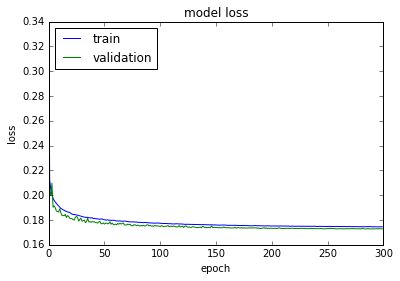

In [9]:
# Validation
#loss_and_metrics = model.evaluate(x_test, y_test, batch_size=4096)

if training_seq or training_func or training_bn or training_pruned:
    # Loss
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

if False:
    plt.figure()
    plt.plot(history.history['regr_loss'])
    plt.plot(history.history['val_regr_loss'])
    plt.title('regr loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
  
    plt.figure()
    plt.plot(history.history['discr_loss'])
    plt.plot(history.history['val_discr_loss'])
    plt.title('discr loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

### Regression Results

In [10]:
# Setup matplotlib
plt.style.use('tdrstyle.mplstyle')

from nn_plotting import (gaus, fit_gaus, np_printoptions, \
                         find_efficiency_errors)

eps = 1e-7
my_cmap = plt.cm.viridis
my_cmap.set_under('w',1)
my_palette = ("#377eb8", "#e41a1c", "#984ea3", "#ff7f00", "#4daf4a")

In [11]:
# Load model and predict outputs
from nn_models import load_my_model, update_keras_custom_objects
update_keras_custom_objects()
#K.set_learning_phase(0)
loaded_model = load_my_model(name=model_name_MK, weights_name=weights_name_MK)
loaded_model.trainable = False
assert not loaded_model.updates

nentries_test = x_test.shape[0]//4

# Prepare y_test_true, y_test_meas
y_test_true = y_test
if isinstance(y_test_true, list):
    y_test_true = y_test_true[0]
y_test_true = y_test_true[:nentries_test].copy()
y_test_true = y_test_true.reshape(-1)
y_test_true /= reg_pt_scale

y_test_meas = loaded_model.predict(x_test[:nentries_test], batch_size=4096)
if isinstance(y_test_meas, list):
    y_test_meas = y_test_meas[0]
y_test_meas = y_test_meas.reshape(-1)
y_test_meas /= reg_pt_scale
#print y_test_true.shape, y_test_true
#print y_test_meas.shape, y_test_meas

[INFO    ] # of entries: 167319, mean: -0.00139576999936, std: 0.0410457476974
[INFO    ] gaus fit (a, mu, sig): [ 1.44529500e+04 -1.01111864e-03  2.44661757e-02]


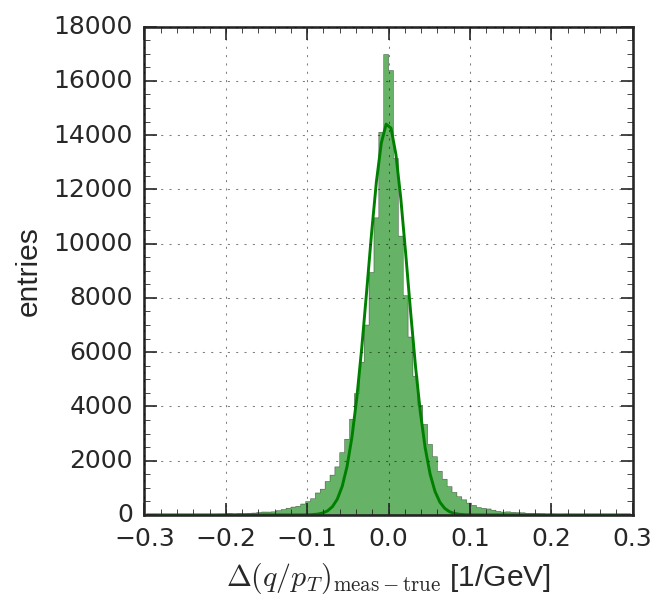

In [12]:
# Plot Delta(q/pT)
plt.figure()
yy = y_test_meas - y_test_true
hist, edges, _ = plt.hist(yy, bins=100, range=(-0.3,0.3-eps), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.3]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
plt.show()

[INFO    ] # of entries: 167319, mean: 0.226391017437, std: 0.245151534677
[INFO    ] gaus fit (a, mu, sig): [ 1.79951520e+04 -6.09147965e-03  1.32592474e-01]


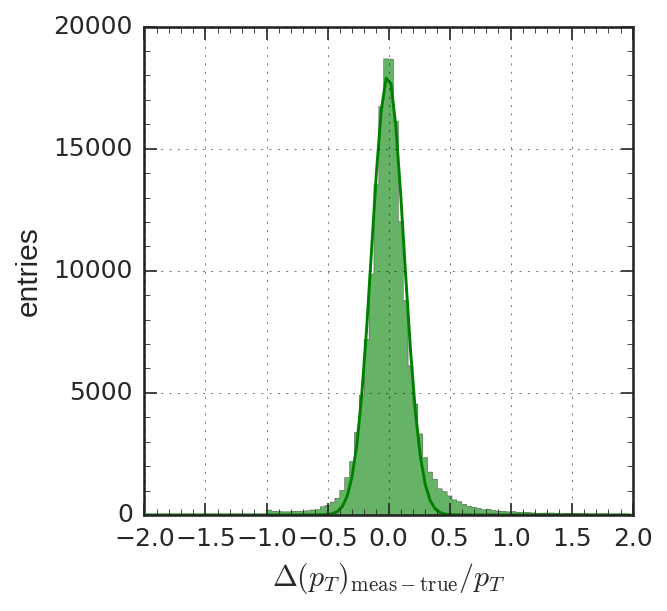

In [13]:
# Plot Delta(q/pT) / pT
plt.figure()
yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)
hist, edges, _ = plt.hist(yy, bins=100, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<2])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<1.5]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-matplotlib/1.5.2-gnimlf2/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


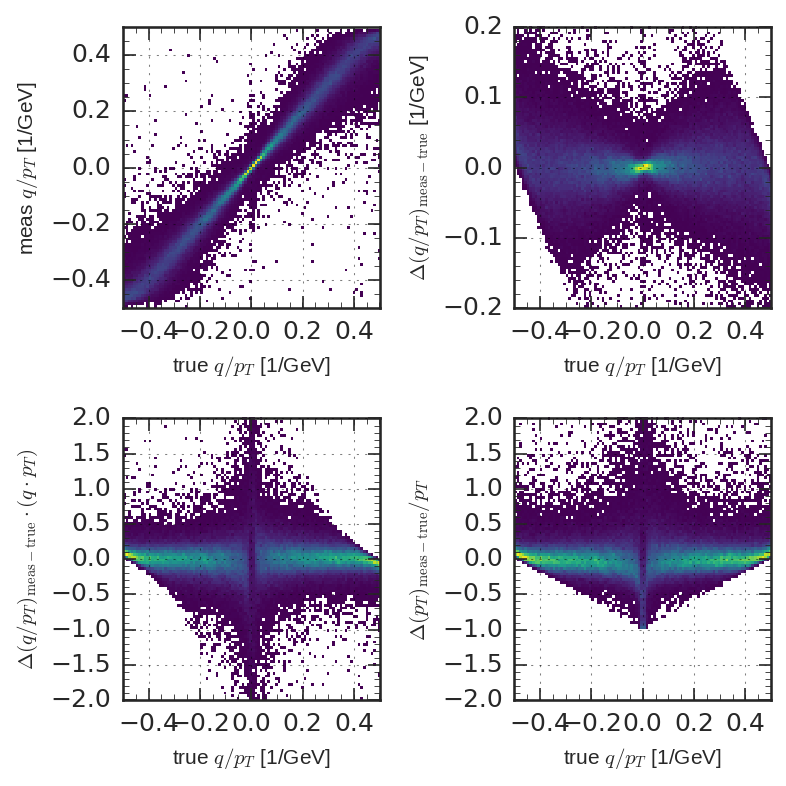

In [14]:
# Plot resolution plots
fig, axs = plt.subplots(2, 2, figsize=(5.4,5.4), tight_layout=True)

axs[0,0].hist2d(y_test_true, y_test_meas, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
axs[0,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,0].set_ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)

yy = y_test_meas - y_test_true
axs[0,1].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-0.2,0.2)), vmin=1, cmap=my_cmap)
axs[0,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,1].set_ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]', fontsize=10)

yy = (y_test_meas - y_test_true)/np.abs(y_test_true)
axs[1,0].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
axs[1,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,0].set_ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}} \cdot (q \cdot p_{T})$', fontsize=10)

yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)
axs[1,1].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
axs[1,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,1].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

plt.show()

In [15]:
# Make better resolution plot
xx = np.abs(y_test_true)
yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  pt = np.mean(xx_i)
  pt = 1.0/pt
  
  yy_i = yy[inds==i]
  yy_i = yy_i[(-1 <= yy_i) & (yy_i <= 1.2)]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  assert(np.abs(mu) < 1)
  assert(np.abs(sig) < 2)
  
  hist, edges = np.histogram(yy_i, bins=100, range=(-2,2))
  #popt = fit_gaus(hist, edges, mu=mu, sig=sig)
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  #print i, len(xx_i), mu, sig, pt, popt
  
  if 20. < pt < 22.:
    xx_20GeV, yy_20GeV, popt_20GeV = xx_i, yy_i, popt
  
  xxx[i] = pt
  yyy[i] = popt[2]

[INFO    ] gaus fit (a, mu, sig): [ 1.15690778e+02 -5.14257565e-02  2.24192870e-01]


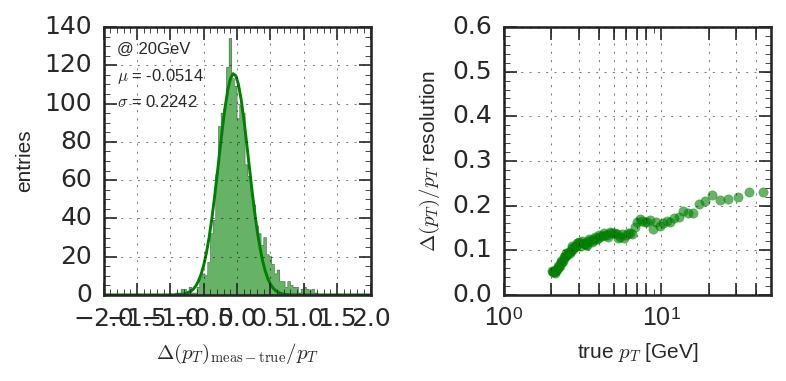

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(5.4,5.4/2), tight_layout=True)

#axs[0].hist2d(xx, yy, bins=(100,100), range=((0,0.5),(-1,3)), vmin=1, cmap=my_cmap)
#axs[0].set_xlabel(r'true $1/p_{T}$ [1/GeV]', fontsize=10)
#axs[0].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

hist, edges, _ = axs[0].hist(yy_20GeV, bins=100, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[0].text(0.05, 0.9, r'@ 20GeV', transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.8, r'$\mu$ = {0:.4f}'.format(popt[1]), transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.7, r'$\sigma$ = {0:.4f}'.format(popt[2]), transform=axs[0].transAxes, fontsize=8)
axs[0].set_xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)
axs[0].set_ylabel(r'entries', fontsize=10)
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))

axs[1].scatter(xxx, yyy, color='g', alpha=0.6)
axs[1].set_xlim(1,50)
axs[1].set_ylim(0,0.6+eps)
axs[1].set_xlabel(r'true $p_{T}$ [GeV]', fontsize=10)
axs[1].set_ylabel(r'$\Delta(p_{T}) / p_{T}$ resolution', fontsize=10)
axs[1].set_xscale('log')
axs[1].set_xticks(range(1,9) + range(10,50,10))

plt.show()

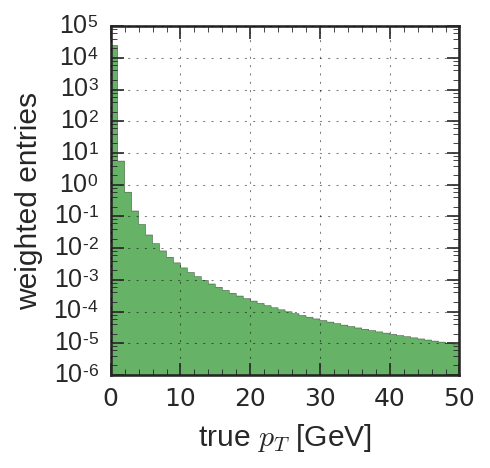

In [17]:
# Mock minbias pT spectrum
xx = np.linspace(0.1, 49.1, num=50)
#reweight = lambda x: 5.5 * np.power(x,-3)
#reweight = lambda x: 11 * np.power(x,-4)
reweight = lambda x: 7.778 * np.power(x,-3.5)
xw = np.fromiter((reweight(xi) for xi in xx), xx.dtype)

plt.figure(figsize=(3,3))
plt.hist(xx, bins=50, range=(0,50), weights=xw, histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'true $p_{T}$ [GeV]')
plt.ylabel(r'weighted entries')
plt.yscale('log')
plt.show()

In [18]:
# Predict 20 GeV rates with 90% coverage
xx = np.abs(1.0/y_test_true)
yy = np.abs(1.0/y_test_meas)

reweight = lambda x, y, thresh: 7.778 * np.power(x,-2.5) if y >= thresh else 0.  # -2.5 instead of -3.5 because the parent distribution is already 1/pT-weighted

nbinsx = 20
xedges = np.linspace(2, 42, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  yy_i = yy[inds==i]
  pct = np.percentile(yy_i, [10, 50, 90], overwrite_input=True)
  #print np.mean(xx_i), len(xx_i), pct
  
  xxx[i] = pct[0]

ind_20GeV = np.digitize(20., xedges[1:])
thresh_20GeV = xxx[ind_20GeV]
yw = np.fromiter((reweight(xi, yi, thresh_20GeV) for (xi, yi) in zip(xx, yy)), xx.dtype)
logger.info("20 GeV threshold {0} rate {1}".format(thresh_20GeV, np.sum(yw)))

ind_22GeV = np.digitize(22., xedges[1:])
thresh_22GeV = xxx[ind_22GeV]
yw = np.fromiter((reweight(xi, yi, thresh_22GeV) for (xi, yi) in zip(xx, yy)), xx.dtype)
logger.info("22 GeV threshold {0} rate {1}".format(thresh_22GeV, np.sum(yw)))

[INFO    ] 20 GeV threshold 14.8742694855 rate 174.440063477
[INFO    ] 22 GeV threshold 15.7415733337 rate 152.81729126


### Classification Results

In [19]:
# Prepare y_test_true, y_test_meas (again)
y_test_true = [y_test[0][:nentries_test].copy(), y_test[1][:nentries_test].copy()]
y_test_meas = loaded_model.predict(x_test[:nentries_test], batch_size=4096)

y_test_sel = (y_test_true[1] != mask_value)  # skip low pT muons
y_test_true[0] /= reg_pt_scale
y_test_meas[0] /= reg_pt_scale
#print y_test_true[0].shape, y_test_true[0], y_test_true[1].shape, y_test_true[1]
#print y_test_meas[0].shape, y_test_meas[0], y_test_meas[1].shape, y_test_meas[1]

# Prepare pu_y_test_true, pu_y_test_meas
pu_y_test_sel = ~(pu_aux_test[:,2] > discr_pt_cut)  # veto PU events with high-pT tracks
pu_y_test_true = [pu_y_test[0].copy(), pu_y_test[1].copy()]
pu_y_test_meas = loaded_model.predict(pu_x_test, batch_size=4096)
#pu_y_test_true[0] /= reg_pt_scale
pu_y_test_meas[0] /= reg_pt_scale
#print pu_y_test_true[0].shape, pu_y_test_true[0], pu_y_test_true[1].shape, pu_y_test_true[1]
#print pu_y_test_meas[0].shape, pu_y_test_meas[0], pu_y_test_meas[1].shape, pu_y_test_meas[1]

In [20]:
def roc_singlemu(x_mask):
  valid = ~x_mask
  mode = np.int32(0)
  if np.any([valid[0], valid[1], valid[5], valid[9], valid[11]]):   # ME1/1, ME1/2, RE1/2, GE1/1, ME0
    mode |= (1<<3)
  if np.any([valid[2], valid[6], valid[10]]):  # ME2, RE2, GE2/1
    mode |= (1<<2)
  if np.any([valid[3], valid[7]]):  # ME3, RE3
    mode |= (1<<1)
  if np.any([valid[4], valid[8]]):  # ME4, RE4
    mode |= (1<<0)
  return mode in (11,13,14,15)

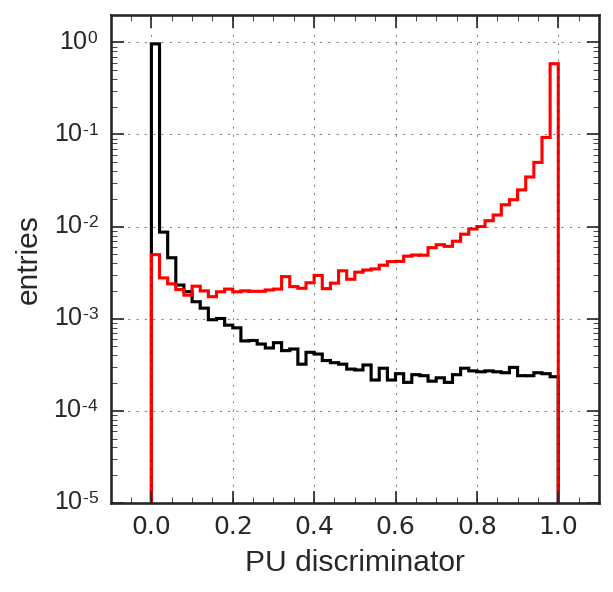

In [21]:
# Plot discriminator
plt.figure()
xx = pu_y_test_meas[1][pu_y_test_sel]
xw = np.ones_like(xx)/float(len(xx))
yy = y_test_meas[1][y_test_sel]
yw = np.ones_like(yy)/float(len(yy))
plt.hist(xx, bins=50, range=(0,1), weights=xw, histtype='step', color='black', lw=1.5)
plt.hist(yy, bins=50, range=(0,1), weights=yw, histtype='step', color='red', lw=1.5)
plt.xlabel(r'PU discriminator')
plt.ylabel(r'entries')
plt.xlim(-0.1, 1.1)
plt.ylim(1e-5, 2)
plt.yscale('log')
plt.show()

# Calculate separation score?

[INFO    ] auc: 0.958332297852
[INFO    ] thr: [0.8846, 0.8508, 0.8013, 0.7358, 0.7072, 0.6749, 0.6276, 0.5563, 0.1323]
[INFO    ] tpr: [0.9001, 0.9258, 0.9503, 0.9701, 0.9753, 0.9801, 0.9854, 0.9901, 0.9990]
[INFO    ] fpr: [0.1370, 0.1676, 0.2151, 0.2612, 0.2775, 0.2951, 0.3155, 0.3338, 0.4891]


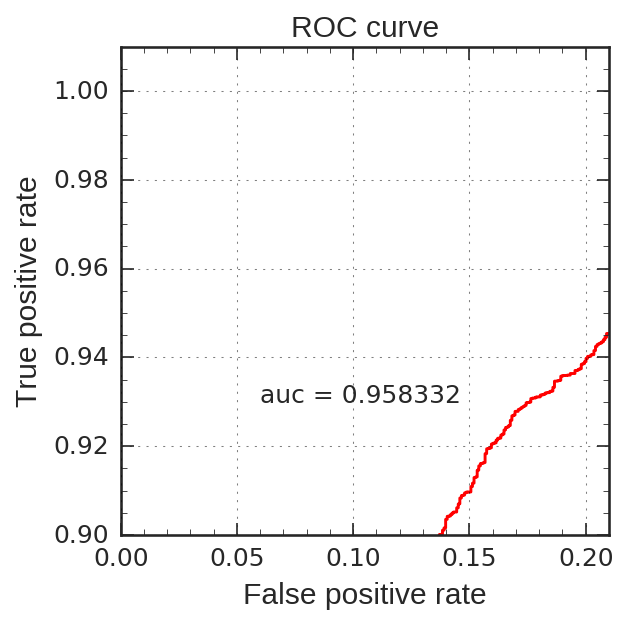

In [22]:
# Plot ROC
from sklearn.metrics import roc_curve, roc_auc_score

xx = np.concatenate((y_test_true[1][y_test_sel], pu_y_test_true[1][pu_y_test_sel]))
yy = np.concatenate((y_test_meas[1][y_test_sel], pu_y_test_meas[1][pu_y_test_sel]))
zz = np.concatenate((y_test_meas[0][y_test_sel], pu_y_test_meas[0][pu_y_test_sel]))
tt = np.concatenate((x_mask_test[:nentries_test][y_test_sel], pu_x_mask_test[pu_y_test_sel]))

tt = np.apply_along_axis(roc_singlemu, 1, tt)  # require SingleMu quality
xx = xx[:, np.newaxis]
xx = xx[tt]
yy = yy[tt]
zz = zz[tt]

zzz = np.abs(1.0/zz) > discr_pt_cut  # meas pT > 8 GeV
xxx = xx[zzz]
yyy = yy[zzz]

fpr, tpr, thresh = roc_curve(xxx, yyy)  # (y_true, y_meas)
auc = roc_auc_score(xxx, yyy)           # (y_true, y_meas)

idx = np.searchsorted(tpr, [0.9, 0.925, 0.95, 0.97, 0.975, 0.98, 0.985, 0.99, 0.999])
logger.info("auc: {0}".format(auc))
logger.info("thr: {0}".format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("tpr: {0}".format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("fpr: {0}".format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

plt.figure()
plt.plot(fpr, tpr, 'r')
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.text(0.06, 0.93, r'auc = %f' % auc, fontsize=12)
plt.xlim(0.0,0.21)
plt.ylim(0.9,1.01)
plt.show()

[INFO    ] auc: 0.98476434663
[INFO    ] thr: [0.9710, 0.9519, 0.9298, 0.8798, 0.8508, 0.8171, 0.7542, 0.6551, 0.1686]
[INFO    ] tpr: [0.9012, 0.9352, 0.9523, 0.9700, 0.9756, 0.9802, 0.9861, 0.9904, 0.9990]
[INFO    ] fpr: [0.0332, 0.0464, 0.0498, 0.0763, 0.0813, 0.0962, 0.1078, 0.1360, 0.3234]


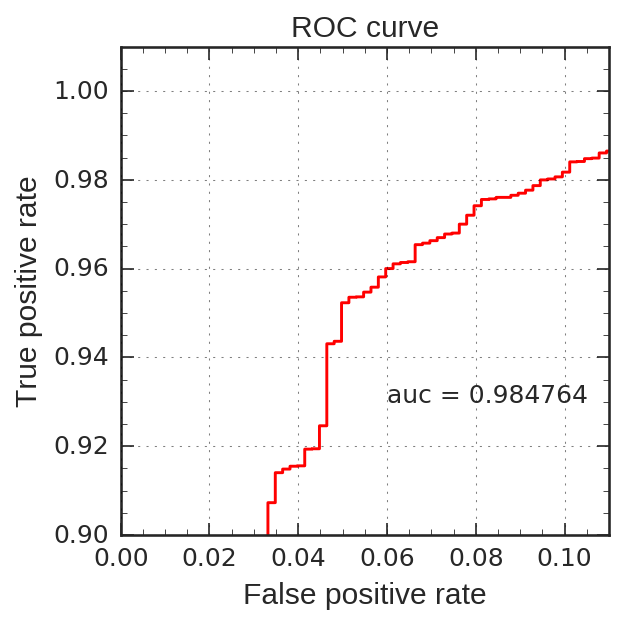

In [23]:
# Plot ROC (for pT > 14 GeV)
zzz = np.abs(1.0/zz) > 14
xxx = xx[zzz]
yyy = yy[zzz]

fpr, tpr, thresh = roc_curve(xxx, yyy)  # (y_true, y_meas)
auc = roc_auc_score(xxx, yyy)           # (y_true, y_meas)

idx = np.searchsorted(tpr, [0.9, 0.925, 0.95, 0.97, 0.975, 0.98, 0.985, 0.99, 0.999])
logger.info("auc: {0}".format(auc))
logger.info("thr: {0}".format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("tpr: {0}".format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("fpr: {0}".format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

plt.figure()
plt.plot(fpr, tpr, 'r')
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.text(0.06, 0.93, r'auc = %f' % auc, fontsize=12)
plt.xlim(0.0,0.11)
plt.ylim(0.9,1.01)
plt.show()

### Efficiency & Rates 

In [24]:
# Build track producer

from six.moves import range, zip, map, filter

pt_bins = (-0.5, -0.365, -0.26, -0.155, -0.07, 0.07, 0.155, 0.26, 0.365, 0.5)

theta_to_eta_lut = [
   2.599, 2.566, 2.534, 2.503, 2.473, 2.444, 2.415, 2.388, 2.361, 2.334,
   2.309, 2.284, 2.259, 2.236, 2.212, 2.19 , 2.167, 2.145, 2.124, 2.103,
   2.083, 2.063, 2.043, 2.024, 2.005, 1.986, 1.968, 1.95 , 1.932, 1.915,
   1.898, 1.881, 1.864, 1.848, 1.832, 1.816, 1.8  , 1.785, 1.77 , 1.755,
   1.74 , 1.726, 1.711, 1.697, 1.683, 1.67 , 1.656, 1.642, 1.629, 1.616,
   1.603, 1.59 , 1.578, 1.565, 1.553, 1.541, 1.529, 1.517, 1.505, 1.493,
   1.482, 1.47 , 1.459, 1.448, 1.436, 1.425, 1.415, 1.404, 1.393, 1.382,
   1.372, 1.362, 1.351, 1.341, 1.331, 1.321, 1.311, 1.301, 1.291, 1.282,
   1.272, 1.262, 1.253, 1.244, 1.234, 1.225, 1.216, 1.207, 1.198, 1.189,
]

def find_pt_bin(pt):
  ipt = np.digitize((pt,), pt_bins[1:])[0]  # skip lowest edge
  ipt = np.clip(ipt, 0, len(pt_bins)-2)
  return ipt

def find_emtf_road_quality(ipt):
  best_ipt = find_pt_bin(0.)
  return best_ipt - np.abs(ipt - best_ipt)

nvariables = nvariables

discr_pt_cut = discr_pt_cut

def get_theta_median_from_x(x):
  assert(x.shape[0] == nvariables)
  theta_median = x[-1] # last variable
  theta_median = (theta_median * 83) + 3
  return theta_median.astype(np.int32)

def get_zone_from_x(x):
  assert(x.shape[0] == nvariables)
  zone = x[-2] # second last variable
  zone = (zone * 5) + 0
  return zone.astype(np.int32)

def get_straightness_from_x(x):
  assert(x.shape[0] == nvariables)
  straightness = x[-3] # third last variable
  straightness = (straightness * 4) + 4
  return straightness.astype(np.int32)

def get_ndof_from_x_mask(x_mask):
  assert(x_mask.shape[0] == nlayers)
  assert(x_mask.dtype == np.bool)
  valid = ~x_mask
  return valid.sum()

def get_mode_from_x_mask(x_mask):
  assert(x_mask.shape[0] == nlayers)
  assert(x_mask.dtype == np.bool)
  valid = ~x_mask
  mode = np.int32(0)
  if np.any([valid[0], valid[1], valid[5], valid[9], valid[11]]):   # ME1/1, ME1/2, RE1/2, GE1/1, ME0
    mode |= (1<<3)
  if np.any([valid[2], valid[6], valid[10]]):  # ME2, RE2, GE2/1
    mode |= (1<<2)
  if np.any([valid[3], valid[7]]):  # ME3, RE3
    mode |= (1<<1)
  if np.any([valid[4], valid[8]]):  # ME4, RE4
    mode |= (1<<0)

  # Apply modified SingleMu requirement
  mode_me0 = np.int32(0)
  if valid[11]: # ME0
    mode_me0 |= (1 << 2)
  if valid[0]:  # ME1/1
    mode_me0 |= (1 << 1)
  if np.any([valid[2], valid[3], valid[4]]):  # ME2, ME3, ME4
    mode_me0 |= (1 << 0)
  if mode not in (11,13,14,15) and mode_me0 == 7:
    mode = 11  # pretend as mode 11
  return mode

class TrackProducer(object):
  def __init__(self):
    self.s_min = 0.
    self.s_max = 60.
    self.s_nbins = 120
    self.s_step = (self.s_max - self.s_min)/self.s_nbins
    self.s_lut =[ 1.8005,  1.5194,  1.5708,  1.8247,  2.1989,  2.6489,  3.1625,  3.7251,
                  4.3240,  4.9595,  5.6337,  6.3424,  7.0590,  7.7485,  8.4050,  9.0398,
                  9.6598, 10.2800, 10.9236, 11.6060, 12.3216, 13.0521, 13.7887, 14.5427,
                 15.2964, 16.0232, 16.7303, 17.4535, 18.2066, 19.0044, 19.8400, 20.6934,
                 21.5215, 22.3143, 23.1066, 23.8221, 24.4586, 25.1335, 25.9083, 26.7333,
                 27.5310, 28.2623, 28.9778, 29.7226, 30.5507, 31.4670, 32.4541, 33.5263,
                 34.5659, 35.5155, 36.4457, 37.4019, 38.3762, 39.3604, 40.3595, 41.3763,
                 42.3333, 43.2434, 44.2686, 45.5962, 47.0878, 48.3783, 49.4891, 50.5445,
                 51.4431, 52.2846, 53.1180, 53.9492, 54.7793, 55.6090, 56.4384, 57.2676,
                 58.0967, 58.9257, 59.7547, 60.5836, 61.4125, 62.2413, 63.0702, 63.8990,
                 64.7278, 65.5566, 66.3854, 67.2142, 68.0430, 68.8718, 69.7006, 70.5293,
                 71.3581, 72.1869, 73.0157, 73.8444, 74.6732, 75.5020, 76.3307, 77.1595,
                 77.9882, 78.8170, 79.6458, 80.4745, 81.3033, 82.1321, 82.9608, 83.7896,
                 84.6183, 85.4471, 86.2759, 87.1046, 87.9334, 88.7621, 89.5909, 90.4197,
                 91.2484, 92.0772, 92.9059, 93.7347, 94.5635, 95.3922, 96.2210, 97.0497]
    #self.s_lut = np.linspace(self.s_min, self.s_max, num=self.s_nbins+1)[:-1]
    self.s_step = np.asarray(self.s_step)
    self.s_lut = np.asarray(self.s_lut)

  def get_trigger_pt(self, x, y_meas):
    xml_pt = np.abs(1.0/y_meas)
    if xml_pt <= 2.:  # do not use the LUT if below 2 GeV
      return xml_pt

    def digitize(x, bins=(self.s_nbins, self.s_min, self.s_max)):
      x = np.clip(x, bins[1], bins[2]-1e-5)
      binx = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
      return binx.astype(np.int32)

    def interpolate(x, x0, x1, y0, y1):
      y = (x - x0) / (x1 - x0) * (y1 - y0) + y0
      return y

    binx = digitize(xml_pt)
    if binx == self.s_nbins-1:  # check boundary
      binx -= 1

    x0, x1 = binx * self.s_step, (binx+1) * self.s_step
    y0, y1 = self.s_lut[binx], self.s_lut[binx+1]
    pt = interpolate(xml_pt, x0, x1, y0, y1)
    return pt

  def pass_trigger(self, strg, ndof, mode, theta_median, y_meas, y_discr, discr_pt_cut=14.):
    ipt1 = strg
    ipt2 = find_pt_bin(y_meas)
    quality1 = find_emtf_road_quality(ipt1)
    quality2 = find_emtf_road_quality(ipt2)

    if mode in (11,13,14,15) and quality2 <= (quality1+1):
      if np.abs(1.0/y_meas) > 14:
        trigger = (y_discr > 0.9136) # 98.0% coverage
      elif np.abs(1.0/y_meas) > discr_pt_cut:
        trigger = (y_discr > 0.7415) # 98.0% coverage
      else:
        trigger = (y_discr >= 0.)  # True
    else:
      trigger = (y_discr < 0.)  # False
    return trigger

  def run(self, slim_roads, variables, predictions, other_vars):
    assert(len(slim_roads) == len(variables))
    assert(len(slim_roads) == len(predictions))
    assert(len(slim_roads) == len(other_vars))

    tracks = []

    for myroad, myvars, mypreds, myother in zip(slim_roads, variables, predictions, other_vars):
      assert(len(myvars.shape) == 1)
      x = myvars
      x_mask = myother
      y_meas = np.asscalar(mypreds[...,0])
      y_discr = np.asscalar(mypreds[...,1])

      theta_median = get_theta_median_from_x(x)
      zone = get_zone_from_x(x)
      strg = get_straightness_from_x(x)
      ndof = get_ndof_from_x_mask(x_mask)
      mode = get_mode_from_x_mask(x_mask)

      passed = self.pass_trigger(strg, ndof, mode, theta_median, y_meas, y_discr, discr_pt_cut=discr_pt_cut)
      xml_pt = np.abs(1.0/y_meas)
      pt = self.get_trigger_pt(x, y_meas)

      if passed:
        trk_q = np.sign(y_meas)
        trk_emtf_phi = myroad.id[4]
        trk_emtf_theta = myroad.theta_median
        trk = Track(myroad.id, myroad.hits, mode, xml_pt, pt, trk_q, trk_emtf_phi, trk_emtf_theta, ndof, y_discr)
        tracks.append(trk)
    return tracks

mytrigger = TrackProducer()

In [25]:
# Efficiency
eff_data = []

for ievt, (x, x_mask, y_meas, y_discr, y_true) in enumerate(zip(x_test, x_mask_test, y_test_meas[0], y_test_meas[1], y_test_true[0])):
  theta_median = get_theta_median_from_x(x)
  zone = get_zone_from_x(x)
  strg = get_straightness_from_x(x)
  ndof = get_ndof_from_x_mask(x_mask)
  mode = get_mode_from_x_mask(x_mask)
  
  passed = mytrigger.pass_trigger(strg, ndof, mode, theta_median, y_meas, y_discr, discr_pt_cut=discr_pt_cut)
  xml_pt = np.abs(1.0/y_meas)
  pt = mytrigger.get_trigger_pt(x, y_meas)
  pt_true = np.abs(1.0/y_true)
  
  eff_data.append((zone, pt_true, xml_pt, pt, passed, theta_median))
  
  # Debug
  if ievt < 20.:
    print ievt, ndof, float(y_discr), float(pt_true), float(xml_pt), float(pt), passed
  
eff_data = np.asarray(eff_data)

0 3 0.000145766767673 3.89396537138 4.21160316467 4.5929476223 [ True]
1 4 0.000379279343178 4.42436284899 4.48602676392 4.94174001694 [ True]
2 3 0.0490378476679 5.40970385582 5.17341566086 5.8794993577 [ True]
3 3 2.28232947848e-05 2.89595154569 2.73408436775 2.88935146255 [ True]
4 4 7.50789840822e-05 3.94286688583 3.06806588173 3.23908773012 [ True]
5 3 8.32697514852e-06 2.06544204286 2.22625565529 2.40253008976 [ True]
6 3 0.899121999741 8.82736848876 8.99412727356 10.9160406265 [False]
7 4 0.217459455132 6.13448637913 6.30665445328 7.48187649107 [ True]
8 3 0.999255955219 12.6086367712 16.9620323181 23.0464364113 [ True]
9 4 0.993095576763 34.1395063245 25.8371353149 38.0588418747 [ True]
10 4 3.56840064342e-05 3.23169699759 2.77970576286 2.93621375961 [ True]
11 4 7.62717609177e-05 3.93265050598 3.61339449883 3.86092393069 [ True]
12 3 0.999195992947 24.7641472106 31.5637874603 50.6591388237 [ True]
13 2 2.19752109842e-05 2.29566190208 2.21514058113 2.39252652302 [False]
14 3 0.

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-numpy/1.14.1-gnimlf/lib/python2.7/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-numpy/1.14.1-gnimlf/lib/python2.7/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


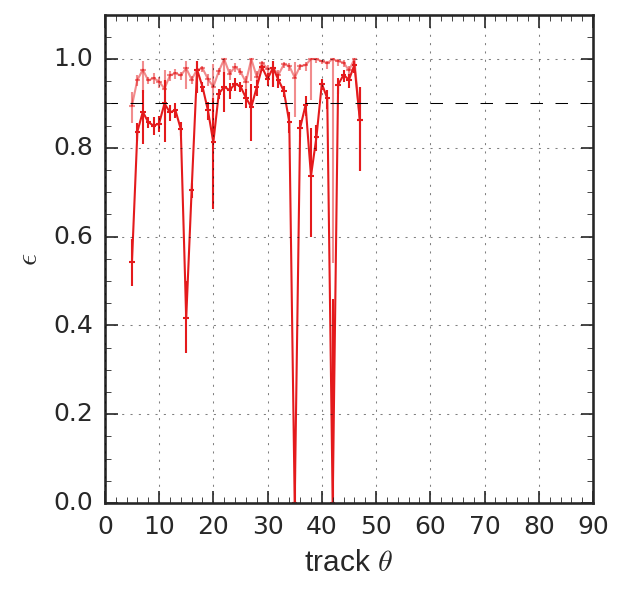

In [26]:
# Efficiency
plt.figure()

pt = 20
color = my_palette[1]
gen_passed = eff_data[:, 1] > 30  # index 1 is pt_true
passed = gen_passed & (eff_data[:, 3] > pt) & (eff_data[:, 4] == 1)  # index 3 is pt, index 4 is passed

denom_hist, edges = np.histogram(eff_data[:, 5][gen_passed], bins=89, range=(0.5,89.5))  # index 5 is theta_median
num_hist, edges = np.histogram(eff_data[:, 5][passed], bins=89, range=(0.5,89.5))  # index 1 is pt_true
eff_hist = np.true_divide(num_hist, denom_hist)

xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2
yerr = find_efficiency_errors(denom_hist, num_hist)
ydata = eff_hist
#print pt, ydata

plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)

passed = gen_passed & (eff_data[:, 3] > pt) & (eff_data[:, 4] >= 0)  # index 3 is pt, index 4 is passed
num_hist, edges = np.histogram(eff_data[:, 5][passed], bins=89, range=(0.5,89.5))  # index 1 is pt_true
eff_hist = np.true_divide(num_hist, denom_hist)
yerr = find_efficiency_errors(denom_hist, num_hist)
ydata = eff_hist

plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, alpha=0.5, marker=',', capsize=0, lw=1)
  
plt.plot([0,90], [0.9,0.9], ls='dashed', lw=0.5, color='black')
plt.xlim(0,90)
plt.ylim(0,1.1)
plt.xlabel(r'track $\theta$')
plt.ylabel(r'$\epsilon$')
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


15 [           nan            nan            nan            nan
 6.12107486e-05 1.71092253e-04 8.48656294e-04 3.23168711e-03
 7.18340864e-03 2.05273962e-02 7.63680764e-02 2.78294705e-01
 5.59622196e-01 7.71656051e-01 8.43241042e-01 8.83969466e-01
 8.86238532e-01 8.71891485e-01 9.04501217e-01 9.07874016e-01
 9.01467505e-01 9.11872705e-01 9.07040328e-01 8.97489540e-01
 8.95918367e-01 9.02456140e-01]
25 [           nan            nan            nan            nan
 4.08071657e-05 3.42184506e-05 2.26308345e-04 9.94365264e-04
 1.73792145e-03 3.00015790e-03 8.65800866e-03 2.40230080e-02
 6.46989374e-02 1.39171975e-01 2.78908795e-01 4.77862595e-01
 6.15902141e-01 7.09871891e-01 8.03527981e-01 8.59842520e-01
 8.74912648e-01 8.95348837e-01 8.94736842e-01 8.91910739e-01
 8.89795918e-01 8.95438596e-01]


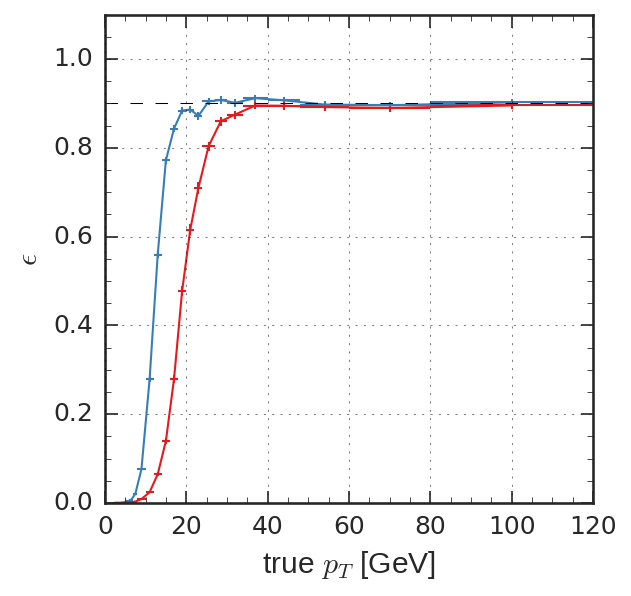

In [27]:
# Efficiency
eff_pt_bins = (0., 0.5, 1., 1.5, 2., 3., 4., 5., 6., 7., 8., 10., 12., 14., 16., 18., 20., 22., 24., 27., 30., 34., 40., 48., 60., 80., 120.)

# MK
#pt_list = (10., 20., 30., 40., 50., 60.)
pt_list = (15,25)
plt.figure()

denom_hist, edges = np.histogram(eff_data[:, 1], bins=eff_pt_bins)  # index 1 is pt_true

for pt, color in zip(pt_list, my_palette):
    passed = (eff_data[:, 3] > pt) & (eff_data[:, 4] == 1)  # index 3 is pt, index 4 is passed
    num_hist, edges = np.histogram(eff_data[:, 1][passed], bins=eff_pt_bins)  # index 1 is pt_true
    eff_hist = np.true_divide(num_hist, denom_hist)
    
    xdata = (edges[1:] + edges[:-1])/2
    xerr = (edges[1:] - edges[:-1])/2
    yerr = find_efficiency_errors(denom_hist, num_hist)
    ydata = eff_hist
    
    ##########################################################
    ###########             Save           ###################    
    np.save(model_name_MK+'_eff_xdata'+str(pt)+'GeV',xdata)
    np.save(model_name_MK+'_eff_xerr'+str(pt)+'GeV',xerr)
    np.save(model_name_MK+'_eff_yerr'+str(pt)+'GeV',yerr)
    np.save(model_name_MK+'_eff_ydata'+str(pt)+'GeV',ydata)
    ##########################################################
    print pt, ydata
    
    plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)

plt.plot([0,120], [0.9,0.9], ls='dashed', lw=0.5, color='black')
plt.xlim(0,120)
plt.ylim(0,1.1)
plt.xlabel(r'true $p_{T}$ [GeV]')
plt.ylabel(r'$\epsilon$')
plt.show()

In [ ]:
# skip

In [ ]:
# Find out pT scale factor

nbinsx = 120
xedges = np.linspace(0, 60, num=nbinsx+1)  # 0.5GeV step size

xxx = np.zeros((4,nbinsx), dtype=np.float32)

for j in xrange(4):  # j = zone0-1, zone2-4, zone5-6, all zones
  if j == 0:
    eff_data_tmp = np.logical_or(eff_data[:,0]==0, eff_data[:,0]==1)
  elif j == 1:
    eff_data_tmp = np.logical_or(eff_data[:,0]==2, eff_data[:,0]==3, eff_data[:,0]==4)
  elif j == 2:
    eff_data_tmp = np.logical_or(eff_data[:,0]==5, eff_data[:,0]==6)
  elif j == 3:
    eff_data_tmp = (eff_data[:,0] >= 0)
    
  xx = eff_data[:,1][eff_data_tmp]  # pt_true
  yy = eff_data[:,2][eff_data_tmp]  # xml_pt
  zz = eff_data[:,4][eff_data_tmp]  # discr_passed
  
  ind = np.digitize(xx, xedges[1:])
  
  for i in xrange(nbinsx):  # i = pT in 0.5GeV step
    if xedges[i] <= 2:  # ignore below 2 GeV
      xxx[j,i] = xedges[i]
      continue
    
    if xedges[i] <= 24:
      step = 4  # 2GeV step size
    elif xedges[i] <= 32:
      step = 8  # 4GeV step size
    elif xedges[i] <= 36:
      step = 12 # 6GeV step size
    else:
      step = 16 # 8GeV step size
    xx_i = xx[(i <= ind) & (ind <= i+step)]
    yy_i = yy[(i <= ind) & (ind <= i+step)]
    zz_i = zz[(i <= ind) & (ind <= i+step)]
    coverage = 90  
    coverage += 1.0 # inefficiency due to fiducial cuts
    #coverage += 1.5 # inefficiency due to fiducial cuts
    #pct = np.percentile(yy_i, 100-coverage, overwrite_input=True)
    
    yz_i = np.where(zz_i==0, 0, yy_i)
    pct = np.percentile(yz_i, 100-coverage, overwrite_input=True)
    
    xxx[j,i] = pct
    
    # Debug
    if j == 3 and 14 <= xedges[i] <= 30:
      print xedges[i], 100. * (zz_i==0).sum() / (zz_i>=0).sum()
    #print np.mean(xx_i), len(xx_i), pct
    #if xedges[i] == 20:
    #  print i, coverage, np.percentile(yy_i, [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)
    #  print i, coverage, np.percentile(yy_i[zz_i==1], [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)

#print np.array2string(xxx, separator=', ', precision=4, floatmode='fixed')

In [ ]:
plt.figure()

xdata = (xedges[1:] + xedges[:-1])/2
plt.plot(xxx[0,:-16], xdata[:-16])
plt.plot(xxx[1,:-16], xdata[:-16])
plt.plot(xxx[2,:-16], xdata[:-16])
plt.plot(xxx[3,:-16], xdata[:-16])
plt.xlabel(r'$p_{T}$ [GeV]')
plt.ylabel(r'$p_{T}$ after scale factor [GeV]')

from scipy.interpolate import Rbf
rbf0 = Rbf(xxx[0,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
rbf1 = Rbf(xxx[1,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
rbf2 = Rbf(xxx[2,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
rbf3 = Rbf(xxx[3,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')

xdata = xedges[:-1]
ydata0 = rbf0(xdata)
ydata1 = rbf1(xdata)
ydata2 = rbf2(xdata)
ydata3 = rbf3(xdata)

line0, = plt.plot(xdata, ydata0)
line1, = plt.plot(xdata, ydata1)
line2, = plt.plot(xdata, ydata2)
line3, = plt.plot(xdata, ydata3)

print np.array2string(xdata, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata0, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata1, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata2, separator=', ', precision=4, floatmode='fixed')
print np.array2string(ydata3, separator=', ', precision=4, floatmode='fixed')

def monotoically_increasing(a):
  return np.all(a[1:] >= a[:-1], axis=-1)
assert(monotoically_increasing(ydata3[4:]))

plt.legend((line0, line1, line2, line3), ('zone0-1', 'zone2-4', 'zone5-6', 'all zones'), loc='upper left')
plt.show()

In [ ]:
# restart

In [28]:
# Rates
rates_jobid_offset = 101
rates_njobs = 63
rates_nevents_per_job = 8000
rates_nevents_last_job = 2400
rates_nevents = 498400
assert(rates_nevents == (rates_njobs-1)*rates_nevents_per_job + rates_nevents_last_job)

# Stores highest track pt per event
rates_array = np.zeros((rates_njobs-1,rates_nevents_per_job), dtype=np.float32)
rates_array_last_job = np.zeros((1,rates_nevents_last_job), dtype=np.float32)

for ievt, (x, x_mask, y_meas, y_discr, aux) in enumerate(zip(pu_x_test, pu_x_mask_test, pu_y_test_meas[0], pu_y_test_meas[1], pu_aux_test)):
  theta_median = get_theta_median_from_x(x)
  zone = get_zone_from_x(x)
  strg = get_straightness_from_x(x)
  ndof = get_ndof_from_x_mask(x_mask)
  mode = get_mode_from_x_mask(x_mask)
  
  passed = mytrigger.pass_trigger(strg, ndof, mode, theta_median, y_meas, y_discr, discr_pt_cut=discr_pt_cut)
  #xml_pt = np.abs(1.0/y_meas)
  pt = mytrigger.get_trigger_pt(x, y_meas)
  #pt_true = np.abs(1.0/y_true)
  
  (jobid, ievt, highest_part_pt, highest_track_pt) = aux
  jobid = int(jobid) - rates_jobid_offset
  ievt = int(ievt)
  
  trk_eta = theta_to_eta_lut[theta_median]
  
  if jobid < (rates_njobs-1):
    if passed and (1.24 <= trk_eta <= 2.4):
      rates_array[jobid,ievt] = max(rates_array[jobid,ievt], pt)
  else:  # last job
    if passed and (1.24 <= trk_eta <= 2.4):
      rates_array_last_job[0,ievt] = max(rates_array_last_job[0,ievt], pt)
  
  # Debug
  test_jobs = (31,50,56,60,)
  if jobid in test_jobs and passed and pt > 20.:
    print "{0:4.0f} {1:4.0f} {2:7.4f} {3:7.4f}".format(jobid, ievt, highest_part_pt, highest_track_pt), ndof, pt, y_discr
    if pt > 100.:  # wtf?
      with np_printoptions(precision=3, suppress=True):
        for lay in xrange(nlayers):
          tmp = np.arange(2) * nlayers + lay
          print "....", lay, x[tmp]

  31 2826 19.5646 30.0000 3 [26.79471959] [0.9970847]
  31 5379 18.9197 30.5000 4 [23.91729189] [0.99508274]
  31 6951 11.0130 17.5000 4 [44.13205345] [0.99199814]
  50 2220 16.4247 21.5000 4 [20.30226267] [0.9991543]
  50 2293  6.7106 30.5000 4 [34.32860086] [0.9912435]
  50 4726 11.9545     nan 4 [23.1134754] [0.9983736]
  56 3431 15.0979 21.0000 4 [20.13608921] [0.9974286]
  56 5213 12.2996 21.0000 4 [22.15952883] [0.9907941]
  56 7108 12.3301 33.0000 3 [23.52345004] [0.99671423]
  56 7815 12.3604 15.5000 4 [22.3720215] [0.99819994]
  60  104  2.3890     nan 4 [230.72732027] [0.94223744]
.... 0 [0.101 0.678]
.... 1 [0. 0.]
.... 2 [-0.328 -1.434]
.... 3 [-0.611  0.   ]
.... 4 [-0.056  0.   ]
.... 5 [0. 0.]
.... 6 [0. 0.]
.... 7 [0. 0.]
.... 8 [0. 0.]
.... 9 [0. 0.]
.... 10 [0. 0.]
.... 11 [0. 0.]
  60 2642 14.2474 26.0000 4 [22.35172014] [0.99908817]
  60 2642 14.2474 26.0000 4 [21.96986036] [0.99902916]
  60 4667  8.5752 18.5000 4 [22.4234232] [0.9956619]
  60 7502 12.6943 21.5000 3

[INFO    ] nevents: 258400/498400


<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
(<type 'numpy.ndarray'>, <type 'numpy.ndarray'>)
(<type 'numpy.ndarray'>, <type 'numpy.ndarray'>)


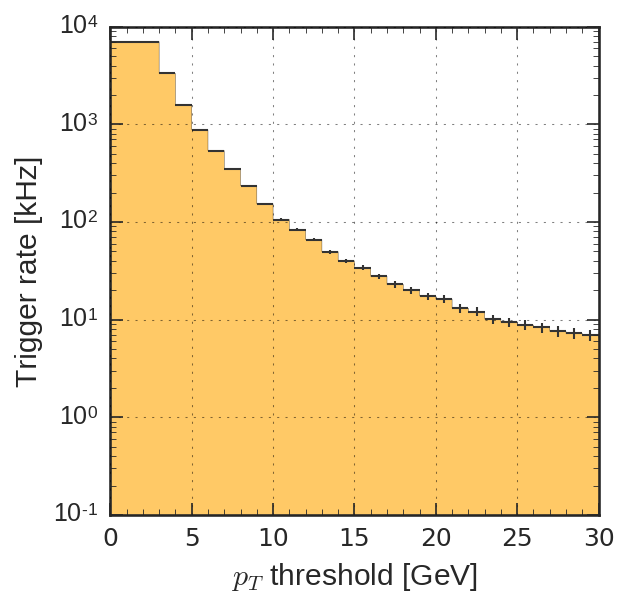

[INFO    ] Rates in kHz at 18/19/20/21/22 GeV: 19.9200433493, 17.4758661985, 16.2537776232, 13.0763474703, 12.0986766219


[7.0244e+03, 7.0244e+03, 7.0230e+03, 3.3194e+03, 1.5874e+03, 8.7880e+02,
 5.3833e+02, 3.4744e+02, 2.3537e+02, 1.5337e+02, 1.0596e+02, 8.3591e+01,
 6.5993e+01, 4.9617e+01, 3.9962e+01, 3.4096e+01, 2.7741e+01, 2.2975e+01,
 1.9920e+01, 1.7476e+01, 1.6254e+01, 1.3076e+01, 1.2099e+01, 1.0143e+01,
 9.4101e+00, 8.7990e+00, 8.3102e+00, 7.5769e+00, 7.2103e+00, 6.9659e+00,
 6.5993e+00, 6.2327e+00, 6.1104e+00, 5.3772e+00, 5.2550e+00, 4.8884e+00,
 4.7661e+00, 4.3995e+00, 4.3995e+00, 4.2773e+00, 4.2773e+00, 4.0329e+00,
 3.9107e+00, 3.7885e+00, 3.7885e+00, 3.6663e+00, 3.6663e+00, 3.6663e+00,
 3.5441e+00, 3.5441e+00, 3.5441e+00, 3.4218e+00, 3.2996e+00, 3.0552e+00,
 2.9330e+00, 2.9330e+00, 2.9330e+00, 2.9330e+00, 2.8108e+00, 2.8108e+00,
 2.8108e+00, 2.5664e+00, 2.5664e+00, 2.5664e+00, 2.5664e+00, 2.3220e+00,
 2.3220e+00, 2.3220e+00, 2.1998e+00, 2.1998e+00, 2.1998e+00, 2.1998e+00,
 2.0776e+00, 2.0776e+00, 2.0776e+00, 2.0776e+00, 2.0776e+00, 2.0776e+00,
 1.9553e+00, 1.8331e+00, 1.8331e+00, 1.8331e+00, 1.

In [29]:
# Rates
rates = np.concatenate((rates_array.reshape(-1), rates_array_last_job.reshape(-1)))
assert(len(rates) == rates_nevents)

# If the rates for a particular jobid is zero, assume the job has failed
rates_nevents_1 = 0
for jobid in xrange(rates_array.shape[0]):
  if rates_array[jobid].sum() > 0.:
    rates_nevents_1 += rates_nevents_per_job
if rates_array_last_job[0].sum() > 0.:
  rates_nevents_1 += rates_nevents_last_job
logger.info("nevents: {0}/{1}".format(rates_nevents_1, rates_nevents))  # should be half the statistics

expected_rates_nevents_1 = 258400
if rates_nevents_1 != expected_rates_nevents_1:
  logger.warning("rates_nevents_1 (which is {0}) != {1}, did some job fail?".format(rates_nevents_1, expected_rates_nevents_1))

def conversion_to_kHz(nevents):
  orbitFreq = 11246.
  nCollBunches = 2808
  nZeroBiasEvents = nevents
  convFactorToHz = orbitFreq * nCollBunches / nZeroBiasEvents
  return (convFactorToHz / 1000.)

rates = rates[rates > eps]
rates = np.clip(rates, 0., 100.)
w = conversion_to_kHz(rates_nevents_1)
weights = np.full_like(rates, w)
print(type(rates))
print(type(weights))
##########################################################
###########             Save           ###################
np.save(model_name_MK+'_rates',rates)
np.save(model_name_MK+'_weights',weights)
##########################################################
plt.figure()
hist, edges, _ = plt.hist(rates, bins=100, range=(0.,100), cumulative=-1, weights=weights, histtype='stepfilled', facecolor='orange', edgecolor='k', alpha=0.6)

xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2
ydata = hist
sumw2 = (ydata/w)
yerr = w*np.sqrt(sumw2)
print(type(xdata),type(xerr))
print(type(ydata),type(yerr))
##########################################################
###########             Save           ###################
np.save(model_name_MK+'_rates_xdata',xdata)
np.save(model_name_MK+'_rates_xerr',xerr)
np.save(model_name_MK+'_rates_ydata',ydata)
np.save(model_name_MK+'_rates_yerr',yerr)
##########################################################
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color='#333333', ecolor='#333333', fmt='none', capsize=0, lw=1)
plt.xlabel(r'$p_{T}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,30)
plt.ylim(1e-1,1e4)
plt.yscale('log')
plt.show()

logger.info("Rates in kHz at 18/19/20/21/22 GeV: {0}, {1}, {2}, {3}, {4}".format(hist[18], hist[19], hist[20], hist[21], hist[22]))
print np.array2string(hist, separator=', ', precision=4, floatmode='fixed')

In [ ]:
# end

In [ ]:
# Old rates
old_hist = [7.7367e+03, 7.7367e+03, 7.7367e+03, 3.0139e+03, 1.3394e+03, 7.0830e+02,
  4.3146e+02, 2.8350e+02, 1.9920e+02, 1.4260e+02, 1.0817e+02, 8.1777e+01,
  6.2449e+01, 4.8319e+01, 3.9061e+01, 2.9235e+01, 1.9896e+01, 1.3156e+01,
  8.9329e+00, 7.0651e+00, 6.7403e+00, 6.2531e+00, 5.3598e+00, 5.0349e+00,
  4.7101e+00, 3.9792e+00, 3.6544e+00, 3.3296e+00, 3.1671e+00, 3.0047e+00,
  2.8423e+00, 2.5987e+00, 2.5175e+00, 2.5175e+00, 2.1926e+00, 2.1926e+00,
  2.1114e+00, 2.0302e+00, 1.8678e+00, 1.7054e+00, 1.7054e+00, 1.6242e+00,
  1.6242e+00, 1.6242e+00, 1.4618e+00, 1.4618e+00, 1.4618e+00, 1.2993e+00,
  1.2993e+00, 1.2993e+00, 1.2993e+00, 1.2993e+00, 1.1369e+00, 1.0557e+00,
  9.7450e-01, 9.7450e-01, 8.9329e-01, 8.9329e-01, 8.9329e-01, 8.9329e-01,
  8.9329e-01, 8.9329e-01, 8.1209e-01, 7.3088e-01, 6.4967e-01, 6.4967e-01,
  5.6846e-01, 5.6846e-01, 5.6846e-01, 5.6846e-01, 5.6846e-01, 5.6846e-01,
  5.6846e-01, 5.6846e-01, 5.6846e-01, 5.6846e-01, 5.6846e-01, 5.6846e-01,
  5.6846e-01, 5.6846e-01, 5.6846e-01, 5.6846e-01, 5.6846e-01, 4.8725e-01,
  4.8725e-01, 4.8725e-01, 4.8725e-01, 4.8725e-01, 4.8725e-01, 4.8725e-01,
  4.8725e-01, 4.8725e-01, 4.8725e-01, 4.8725e-01, 4.8725e-01, 4.8725e-01,
  4.8725e-01, 4.8725e-01, 4.8725e-01, 4.8725e-01]
old_hist = np.array(old_hist, dtype=np.float32)

plt.figure()
centers = (edges[1:] + edges[:-1])/2
plt.hist(centers, weights=old_hist, bins=edges, histtype='step', color='k', lw=1.5)
plt.hist(centers, weights=hist, bins=edges, histtype='step', color='orange', lw=1.5)
plt.xlabel(r'$p_{T}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(1e-1,1e4)
plt.yscale('log')
plt.show()

In [ ]:
# Training history
# 2018-10-16

"""
[INFO    ] Done training. Time elapsed: 2:04:54.658612 sec
[INFO    ] Epoch 300/300 - loss: 0.137361058068 - regr_loss: 2.40064452563 - discr_loss: 0.0173288300487 - val_loss: 0.135927766511 - val_regr_loss: 2.37786404684 - val_discr_loss: 0.0170345622495
"""

from IPython.display import Image
Image(format="png", data="iVBORw0KGgoAAAANSUhEUgAAAZAAAAEZCAYAAAC5AHPcAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAIABJREFUeJzt3Xl8VfWd//HX5yY3ISvZIGFLCAOIQsWVUtwiVIvW1o5bVaijP7uMP1unTmfqMnWp/ro60+m0jrUupdrWUq1jteMCFUzVukBVoig7JGwhCWRPSHKT+/39cU4w0CDJIeGSm/fz8TiP3LPe7/ee5L7zPd+zmHMOERGR/grFugAiIjI0KUBERCQQBYiIiASiABERkUAUICIiEogCREREAlGAiBwGM1tkZnf1cdktZjb3cLcjcrRQgIiISCAKEBERCUQBInHPP3T0L2b2rpk1mtlDZjbazJ4zswYzW2pmI3ss/1kzW21mtWa23Mym9Zh3opm95a+3GBhxwHtdYGbvmFmdmb1qZh8LWOYvmdkGM9ttZn8wszE95v2nmVX5ZSgzs+P86eeb2ft+HbeZ2T8H/tBE+kABIsPFRcBc4BjgM8DzwM3AKCABuAHvS3gq8Jg/Pspf7o9mlmhmYeAp4BEgB3gCuLj7DczsROBh4Ev+/J8Dz/jr9ZnfT/Jd4BJgDLAVWOzPOxc4HZjsnBsJXAbs8Vd9CPiScy4TmAEsH+DPUGQ/ChAZLn7qnNvtnKsEXgHecM6965zr8EPhRH+5y4D/dc4td851Af/utzLmALOBROfcT5xzXc65J4GVPd7jS8D9zrm/Os+vgHZ/vf64EnjYOVfmnIsAtwCzzawQiAAZwHFmZs65dc65Kn+9DmC6mWU45xqcc6sG6LMT6ZUCRIaLqh6v9/Yynu6/HgtUdM9w3t1GtwPj/Hk7DthuRY/XRcA3/ENftWZWB4z31+uPA8vQAtQC45xzLwH3Av8NVJnZ/WbWXfaLgU8DFWb2kpn1N7hE+kUBIrK/nX4Q9DTBD45KPxB6KuzxehvwHedcjj9kO+fSnXO/O5wymFkakNsdXs65e51zpwDH+Yfk/tWf/pZz7nP+obengcf7W3mR/lCAiOzvceDTZna23+/xL0Ab8BrwOhAxs6/58y4CZvVY90HgH81sFv4Xv9+xndbPMvwWuMbMjjezZL8/5HXn3FYzO8XMZplZot9yagOiZhY2syvNLNM/9NYEdA3sRyOyPwWIDAcHPvTmoA/Bcc6tBxb6h4lq/ENCn3HOdfr9ERcB1/gd15cCT/ZY9y2/H+ReM6sF1gP/0Jf37TnPObcMuA34H7/VUQxc4c/O9IOqFtgC7Abu8ed9AdhiZvXAl/2+FJFBY3qglIiIBKEWiIiIBKIAERGRQBQgIiISiAJEREQCSYx1AQaCmelMABGRfnLO2eGsHzctEOdcXA533HFHzMug+ql+ql/8DQMhbgJERESOLAWIiIgEogA5ypWUlMS6CINK9RvaVL/hLS6uRPfuaj306yEicqSYGYfbiR4XZ2EdzMSJE6moqOjDknIkFRUVUV5eHutiiMhhiusWiJ+wMSmTHJz2i0jsDUQLRH0gIiISiAJEREQCUYCIiEggCpAh6rrrruM73/lOrIshIsOYOtFjpLi4mIcffpi5c+fGuihH3NG8X0SGC3Wix6muLj3KWkSOfgqQGLjqqqvYunUrF1xwAZmZmdxzzz2EQiF+8YtfUFRUxLx58wC47LLLGDNmDNnZ2ZSUlPDBBx/s28Y111zD7bffDsCf//xnJkyYwI9+9CPy8/MZN24cv/zlL2NWPxEZHhQgMfDoo49SWFjIs88+S2NjI5dddhkAL7/8MmvXrmXJkiUAnH/++WzatInq6mpOOukkFixYcNBt7tq1i6amJnbu3MlDDz3E9ddfT0NDwxGrk4gMP8M6QMwGZgiqZz+AmfHtb3+blJQUkpOTAbj66qtJTU0lHA5z++23U1ZWRlNTU6/bSkpK4rbbbiMhIYHzzjuP9PR01q1bF7xwIiKHMKwDxLmBGQbK+PHj972ORqPcfPPNTJ48maysLIqLizEzdu/e3eu6ubm5hEIf7s7U1FSam5sHrnAiIgcY1gESS9ZL06XntMcee4w//vGPLF++nPr6esrLywf0QTAiIodLARIjBQUFbN68GXo8TbGnpqYmkpOTyc7OpqWlhVtuuaXX0BERiRUFSIzcfPPN3H333eTk5PDkk0/+TThcddVVFBYWMm7cOGbMmMGcOXP6tX2FjYgMNl1IKEec9otI7OlCQhERiRkFiIiIBKIAERGRQBQgIiISiAJEREQCUYCIiEggChAREQlEASIiIoEoQIaQ7ud+dJsxYwYvv/xyn5btLz0yV0QOJTHWBZD+6XmLktWrV/d52Y/yyCOP8NBDD/HKK6/sm/azn/3sMEopIsOBWiCCc073zhKRflOAxMAPf/hDLr300v2mff3rX+frX/86v/zlLznuuOPIzMxk8uTJPPDAAwfdTnFxMcuXLwegra2Nq6++mpycHGbMmMHKlSv3W/YHP/gBkydPJjMzkxkzZvCHP/wBgLVr13Ldddfx+uuvk5GRQU5ODhzwyFyABx98kClTppCXl8fnPvc5Kisr980LhUL8/Oc/Z+rUqeTk5PDVr351gD4pETmaKUBi4PLLL+f555+npaUF/IdHPf7441x55ZXk5+fve9TtokWLuPHGG1m1atUht3nnnXeyZcsWtmzZwpIlS3jkkUf2mz958mT+8pe/0NjYyB133MHChQupqqpi2rRp3H///XziE5+gqamJ2trav9n28uXLufXWW/n9739PZWUlhYWFXH755fst8+yzz/LWW29RVlbG448/ztKlSw/7cxKRo9uw7gOxbw/MYRt3R//uLFtYWMhJJ53EU089xcKFC1m2bBlpaWnMmjVrv+XOOOMMzj33XF555RVOOOGEj9zmE088wf3338/IkSMZOXIkN9xwA3ffffe++RdffPG+15deeinf/e53WbFiBZ/5zGcOWd7HHnuMa6+9lpkzZwLwve99j+zsbLZu3UphYSEAt9xyCxkZGWRkZHD22WezatUqzj333H59LiIytAzrAOnvF/9AuuKKK/jtb3/LwoUL+e1vf8uVV14JwPPPP89dd93F+vXriUaj7N27l+OPP/6Q29u5c+d+j8QtKirab/6jjz7Kf/7nf1JeXg5AS0vLQR+P29u2Tz755H3jaWlp5ObmsmPHjn0Bkp+fv2++HqcrMjzoEFaMXHrppZSWlrJjxw6eeuopFixYQEdHB5dccgnf/OY3qampoa6ujvPOO69Pz84YM2YM27Zt2zdeUVGx7/XWrVv58pe/zH333UddXR11dXVMnz5933YP1YE+duzY/bbX0tLCnj179gssERl+FCAxkpeXx1lnncU111zDpEmTmDp1Kh0dHXR0dJCXl0coFOL555/vc1/CZZddxve+9z3q6+vZvn0799577755LS0thEIh8vLyiEajLFq0aL9TgPPz89m+fTuRSKTXbV9xxRUsWrSId999l/b2dm699VZmz559WNeZiMjQpwCJoSuvvJJly5axYMECANLT0/nJT37CpZdeSk5ODosXL+bCCy886Po9Ww533HEHhYWFFBcXM3/+fK666qp984499li+8Y1vMHv2bAoKCnj//fc5/fTT982fO3cu06dPp6CggNGjR//N+8ybN4+7776biy66iHHjxrFlyxYWL17cazl6GxeR+KRH2soRp/0iEnt6pK2IiMSMAkRERAJRgIiISCAKEBERCUQBIiIigShAREQkkLi+lUlRUZGuSTgKHXibFREZmuL6OhAREemdrgMREZGYUYCIiEggChAREQlEASIiIoEoQEREJBAFiIiIBKIAERGRQBQgIiISyKAHiJnNN7O1ZrbezG7qZf6VZlbmD6+a2fE95pX7098xsxWDXVYREem7Qb2ViZmFgHuBecBOYKWZPe2cW9tjsc3Amc65BjObDzwAzPbnRYES51zdYJZTRET6b7BbILOADc65CudcBFgM7PeQb+fcG865Bn/0DWBcj9mmw2wiIkenwf5yHgds6zG+/YCAONAXged7jDvgT2a20sy+NIjlFBGRfjpq7sZrZmcD1wCn95h8mnOu0sxG+UGyxjn3agyLKSIivsEOkB1AYY/x8f60/fgd5w8A83v2dzjnKv2fNWb2lH9IrNcAufPOO/e9LikpoaSkZMArIyIyVJWWllJaWjqg2xzU27mbWQKwzu9ErwRWAFc459b0WKYQWAZ8wTn3Ro/pqUDIOddsZmnAUuDbzrmlvbyPbucuItIPA3E790FtgTjnuszsq/6Xfwh42Dm3xsy+4s12DwC3ATnAfeY9/SninJsF5ANPmZnzy/mb3sJDRERiQw+UEhEZhvRAKRERiRkFiIiIBKIAERGRQBQgIiISiAJEREQCUYCIiEggChAREQlEASIiIoEoQEREJBAFiIiIBKIAERGRQBQgIiISiAJEREQCUYCIiEggChAREQlEASIiIoEoQEREJBAFiIiIBKIAERGRQBQgIiISiAJEREQCUYCIiEggChAREQlEASIiIoEoQEREJBAFiIiIBKIAERGRQBQgIiISiAJEREQCUYCIiEggChAREQlEASIiIoEoQEREJBAFiIiIBKIAERGRQBQgIiISiAJEREQCUYCIiEggfQoQM/snM8s0z8Nm9raZnTv4xRMRkaNVX1sg/8c51wicC2QDXwC+P8hlExGRo1hfA8T8n+cDv3LOvd9jmoiIDEN9DZC3zGypHyBLzCwDiA5y2URE5ChmzrlDL2QWAk4ANjvn6s0sBxjvnHv3iJTyEMzM9aUeIiLiMTOcc4d1JKmvLZBPAOv88FgIfAtoOJw3FhGRoa2vAfIzoNXMZgLfADYBjw5y2URE5CjW1wDp9I8RXQjc65z7byBjkMsmIiJHscQ+LtdkZrf4p++e4feJhAe5bCIichTrawvk80C7fz3ILmA8cM8gl01ERI5ifToLC6/HPh841R9d4ZyrHtSS9YPOwhIR6Z8jdhaWmV0GrAAuBS4D3jSzSw7njUVEZGjr63UgZcA53a0OMxsFvOicm3kkCnkoaoGIiPTPkbwOJHTAIas9upOviMjw1tezsF4wsyXAb/3xzwPPDWK5RETkKNenVoRz7l+BB4Dj/eEB59xNfVnXzOab2VozW29mf7OOmV1pZmX+8KqZHd/XdUVEJHb6fBZWoI1714usB+YBO4GVwOXOubU9lpkNrHHONZjZfOBO59zsvqzbYxvqAxER6YeB6AP5yENYZtYE9PbNbF7DxGUeYvuzgA3OuQp/e4v9q9n3hYBz7o0ey78BjOvruiIiEjsfGSDOucO9Xck4YFuP8e1+MBzMF4HnA64rIiJHUF870QedmZ0NXAOcHuuyiIjIoQ12gOwACnuMj/en7cfvOH8AmO+cq+vPut3uvPPOfa9LSkooKSkZoCqIiAx9paWllJaWDug2B7sTPQFY53eEV/pXs1/hnFvTY5lCYBnwhZ79IX1Zt8ey6kQXEemHQe9EP1zOuS4z+yqw1D9l+GHn3Boz+4rfCf8AcBuQA9xnZgZEnHOzDrbuYJZXRET6blBbIEeKWiAiIv1zJG9lIiIish8FiIiIBKIAERGRQOImQNQFIiJyZClAREQkkLgJkGg01iUQERleFCAiIhKIAkRERAJRgIiISCBxEyDqRBcRObLiJkDUAhERObIUICIiEogCREREAlGAiIhIIAoQEREJRAEiIiKBKEBERCSQuAkQXQciInJkxU2AqAUiInJkKUBERCQQBYiIiASiABERkUAUICIiEogCREREAombANFpvCIiR1bcBIhaICIiR5YCREREAlGAiIhIIAoQEREJJG4CpL091iUQERle4iZAqqpiXQIRkeElbgJk585Yl0BEZHiJmwDZsSPWJRARGV7iJkDUAhERObLiJkDUAhERObLiJkDUAhERObLiJkB2VHbFuggiIsNK3ARIw94mXQsiInIExU2AjJrQQGVlrEshIjJ8xE2A5I2vVUe6iMgRFDcBMrJ4I+vWxboUIiLDR9wESNbUDygtjXUpRESGj7gJkGjOGpYv15MJRUSOlLgJkO3tawDYuDHWJRERGR7iJkA27NlAydwuXnwx1iURERke4iZARqWNYs75W3j88ViXRERkeIibAJk+ajq5x73HqlW6L5aIyJEQNwFyVtFZvLp9ORdeCIsXx7o0IiLxL24C5Jy/O4c/bf4T//iP8NOfQiQS6xKJiMS3uAmQEwpOYM/ePeRN3Ujx5A5+85tYl0hEJL7FTYCELMQ5k87hmHuPIX/Bzdx6q27xLiIymMzFwZV3Zuacc9S31bN8y3L+/bV/Z/6O11i2DJYtg8TEWJdQROToYmY45+xwthE3LRCArBFZfHLSJymrKuObN0dIToZvfSvWpRIRiU+DHiBmNt/M1prZejO7qZf5x5jZa2bWZmb/fMC8cjMrM7N3zGxFX94vMzmTwpGFrKv9gF//Gp5+Gr72NYhGB7JWIiIyqAFiZiHgXuBTwHTgCjObdsBie4CvAff0sokoUOKcO9E5N6uv73vK2FNYuXMl6dmtvPEGvPUW3HXX4ddHREQ+NNgtkFnABudchXMuAiwGLuy5gHNut3PuLaCzl/UtSBlPGXMK1z93Pfn/ns8v1/wXTz0Fixahq9RFRAbQYHcvjwO29Rjf7odKXzngT2bWBTzgnHuwLyv9wwn/wKnjTmV02mgueOwCUsOpPP30lzjnHMjMhPnz+18RERHZ39HeiX6ac+4k4HzgejM7vS8rZY3IYs6EOUzOmcwzVzzDTS/exNgp1fzuyXa++EW47Tbo6oKVO1Zy67Jb961X2aRn4oqI9NVgt0B2AIU9xsf70/rEOVfp/6wxs6f81survS1755137ntdUlJCSUkJAFNzp/LZYz7Lg289yMPvPMy3n7iHxbdfzNSpkHPVIt5LWMStZ9xKyEJM+skkNt+wmTEZYw6nziIiR53S0lJKB/ipe4N6HYiZJQDrgHlAJbACuMI5t6aXZe8Amp1z/+GPpwIh51yzmaUBS4FvO+eW9rKu+6h6/Ln8z8x7dB4TRk4gPy2f1699g7/+1TH3j4W0Nqbyidb/x/zTx3DbljN49spnOX/K+QP/YYiIHEWO+utAnHNdwFf9L//3gcXOuTVm9hUz+zJeJfLNbBtwI/BvZrbVzNKBfOBVM3sHeAP4Y2/h0RdnFp3JRcdexJKFS6hpreG6Z/+RJXu/w5hRKfzokn+htfgJfv3Sm+CMr33nHb74RfjggwH/OERE4kpcXYneF+9WvcvSTUt5c8ebnFF4BguPX8jkn0zm2FHHkpYwktb6NM5rfoL77oP/+A/4+Mdh4kSww8ppEZGjy0C0QIZdgPTmxhdu5Mdv/phnLn+GG5fcyMYbNvLUU/DII7BihXdn32nTID0dTp0doeSMMLNnQ2rqgFZDROSIUYD4DjdAtjVs49pnruW5Bc+R9f0svv/J7/P56Z9nVNoonHPs3Gls3AjrqjfzT++fyvTS1axZOYasLDjhBDjnHPj0p2HKlAGtlojIoFGA+A43QHr6was/4LXtr7GjcQdZI7JIDacyt3guL25+kYlZE3m07FG+Pvvr/Nucu6iqgjffhKde3MGy50aSFk6nuBgKC2H8eEhKglNPhdCo9RSPHk3h6CySkwekmCIih0UB4hvIAMHr/OemF28iMzmTD2o+YNWuVUzKnsTzG5/n+QXPs/B/FvKtM7/F2t1rWbZlGTubdnLcqOksOu0v7NiewNat3mN1W1odb7wBr584g4Tyc+j83x/zsY/Bl74Ee/bAjBmQkQHJyVBcDGPHqq9FRI4MBYhvoAOkJ+ccURelrbONl8pf4oKpF7B49WJKy0uZkjOFucVz+Vj+xyj5ZQkXHXsR//wJ736Qe1r3MOcXc7ho2kX85r3f0BJp4YZZ/8RbZXsZ+dfvMWaMd6bX3r3esGkTdHRAKOSNjx4Ns2bB2WdDbi4UFXnhMmqU17oJhweluiIyTChAfIMZIH21bvc6zn/sfPLT8umMdhJOCJOXmscLG1/gh5/8IcvLl7O6ejWN7Y384JM/oLS8lIuPvZiXyl8ie0Q2U3KncFru50hJTCUlxbFjZ5Q3Xk/glVegvh4qKrz3qa6GyuadZKQmExq7isjkJylafR+5eVEuvijE2LEwYoTXqklO9jr+R46E7GyvtdPeDikpaumIDHcKEN/RECAATe1NvFzxMkkJSSzbsow7zrqDDbUbOCb3GOrb6jEzFr2ziO+88h2+NutrLN28lAumXEAkGuGVra+Qk5LDk5c9yY0v3Mjv3v8dV828ipCFWL5lOZFohB9/6secXng6pz44iyRLpaWjhc0NG/jshKtZsu33fGrT++ytzaG93QuKtjZoafECaHdnBa0TniZ51Q0AnHQSpKV5oXLccV7LpqHBu1fYyJH7DxMneq0ghY5I/FCA+I6WAOmLrmgXu1t3k5+ev9/0jq4O5j06jy11W8hOyeb+T9/Psi3L6Ip2MW/SPPa07uEr//sVThl7Cg3tDYQsRHNHM3eedSfXPXsdMwtmcurYU7nr7Lv4VdmvmDNhDjWtNZSWl9LS0cKiVYto72rnnnPuoXTTX4g2juG8UdcRbhvD26s6qat35GaFaWrygqShARoboa4ONm/2xpOSvCE52QueggLYutWblpHhDZmZf/s6M9MLq5YWb92WFu8pkdOmwfTp3vp5edDc7B3CS0z0DtGFw964gktk4ClAfEMpQD5KZ7STTbWbGJsxlozkjL+Zv61hG7945xdcctwljE4bTUukhYlZE+mKdlHRUMEpD5zCmUVn8nbl23R0dRB1Ua6aeRXpSenMLZ5LW2cbn/r1p7hh1g04HItXL6ZkYgmvbXuNY0cdywsLXmBX8y7+tPlPtEZauWLGFWSnZAOws3EXCS6F9TWbWbZ5GRdO+DJNNZkUFcHWhgpe3foXUroKmJRwBntbwjQ2QlOTNzQ2eqGRlua1itLSoLMT3nsP1q/3Wks1u6NkZng3RohEvKGz03sQWDjshVVJidc/tG2b1z/U0eGNdwdOYqI3ZGR4JyjU1np9Sd0B1B2A3f1HjY3ee5900ocnMHR2ejfaBO9nZ6d3+C8p6Uj9FogcGQoQX7wEyOFaXb2aJRuX8IWZX2DVrlWMzxzPcaOO22+Z8vpyJmZNBGDDng2s3LmSqblT+cbSb1DdUk1VcxWfmvwpAJ7b8ByGkRpOZW/nXsIh75v3tMLTWLZ5GTMLZtLW2UZ5fTlnFp1JeX05AH8/7e+pbKokPz2fpIQkjsk9hsKRhbyy9RXK68uZVzyPhvYGdjbt5Pwp5/Pi5he56cWb+L+n/F9uP+t2Oro6uHfFvby9620K0sbwmcl/T2F0LqtWppCaCqPyI6x8M0xGhtfH0x023UNtLaxe7R12q6nxgsHMC4uODm958FpGCQneA8eqq71pPVs9oZA3v77e61cy8wKtoMALFfyw6+jwtpWS4rXYEhK8i0yLi70WV0eHF2TRqBdK3UNCwv6hN2aMt3xtrVf2SOTDkyyamz88Pby2FnJyvDKEerkZUXKyN6+77N2HJUeM8KYBtLZ6283I+DAowfs8e7b4uv+s1AqMPwoQnwLk8O1p3cPKnSs5e+LZJCd6F6vsbt1NyEK0dLQwOm00m+o20RXt4mP5H6N2by1lu8pICCUwe/xskhKScM7x0NsPsWb3GopGFlHTWkN7Zztrdq9hS/0W5oyfw5TcKTz23mOkJ6UzfdR0Xip/iZRwCg9/9mEeevshHnvvMQAWHr+Q8yafx8bajfzP2v/hze1vErIQSQlJtEZaOSbvGM4oPINNdZvYsGcDyYnJnFhwImcVnUVNaw25Kbl0uS5GJI7gobcfYmfTTj4+/uNcPv1yJmZNZGfTTv6w7g/8ufzPzBg9g7Mnns2JY07kmXXPkBhK5JunfRPnHGVVZXRFo3S0JTI+o5DEUCJdjaOJtHq3Iehu/WzdU8OTWx7is393CbvbqshlKnu2jqajw5GUBLt3GwkJ7DfsjmwlHM0ksTOLxkbYtcv7Us/N9UIiHPZCKSXFa7WtW+cFYm6uF1T19R9+wffU1ubNi0QgK8trBdbXe9MTEiAps55oJImUxFSamj4MMee8MElJ+fCwZG2tF4CjRnnb6Rl6PV93D11d+wdmd39cXp43rbnZO4U9NdV7j/Z2r/UXjXotwsZGLwCLirw6dwd796HNnoc3u1udI0Z82KqNRr2wrK72tpOS4n2mbW3edvLzvfDds8cLxZQU73Pq/hyysrzWcna2Ny0U+vCwbUKCN95z6P5Ho7dpznmfRXu79x6pqd5n2tsZlAcGdG+BfahlMjO9Yc8e7/NuaPDeKy3NK0806g1NTV65jj9eAQIKkLhS3VJN9ohswgn7/5U552jvaqets430pHTKdpXxytZXmJg1kePzj6e9s53S8lJW7FzB2PSx1O6tJSGUQH1bPZ+b9jlmjZvFcxue44WNL7CtcRs5KTlcMOUC5k2ax/vV7/NS+UuUVZVx6thTae5o5okPnsAwThxzIkkJSUS6IlQ0VNAV7aKmtYbUcKp3tl0ozLGjjmXd7nWcWXQmSzYtYVL2JCrqK8hOyWZ3627Sk9KZPX427Z3tzMyfSXVLNaUVpTS1N7G3cy/5afmcPPZkirOK2RvZy66WXdTurSU3JZcx6WPIS83jyTVPErIQ8yfPp6WjhaqWKmbmz6Q4u5jlW5aTNSKLaXnT2N26m4r6CkYkjmBi1kRyUnKYljeN7JRsfrbyfk7IP5lvvXQLkWgH1554LROzJpIaTuXtyrc5vfB0Ribmk5s0joq6Hfx1+zuMTEumzTVRsbuKa0/8IuHQCLY3bCcjMZe85LG0treT4EZQ01pDecNG8lIKGJsxhpa6dJxFqO7czLjMsbTUZrBnD4RHdNCWtp7aliYmhmdBuJW/lq+hKHU6WSONrIwwkfYwFRXeF3lBgfdF2d1qi0SguaOFjkiUhM4MOjs/PFkkIdHRHqqlrS6H0aOMSMT78h4xwgsK57yQ7v6CBS9cwmHviz0S8YI2Lc0L6MxMb53uEOzq8sa7v4jYknC0AAAJiElEQVS7h4NNw28NJiV54dTa6n15dx8i/fB3+6PH+7pMXZ0XwLm5Xh2zsrw6tbR4y3cHXFoafPKTcP/9ChBQgMggcc5hvfwr2BntpL6tnpCF2BvZy4baDYzPHM/knMn71mnuaN4XhlUtVZTtKiMpIYn3qt9jVOooTi88nRmjZxB1UdbtWcdbO99iW+M2UhJTKEgvIDslmz2te6hsrqSquYozis4gHAqzYscKUsIpjE4bTdmuMtbXrqekqIT2rnbW7l5L9ohsJudMpiXSwraGbezZu4c1u9ewtWErV8y4gpfKX+LqmVdzWuFpLNm4hM31m6nbW8fJY07mzR1vUtdWx7aGbYzJGMOJBSfSGmklnBAmMymTxz/wngk9LmMctXtrqWqp2ndYMzkxmWl506huqaayqZKoi9IZ7aRwZCHVLdX7DptuqttE0cgiwglhNtZuBGByzmS21G2hy3XhnCM9KR0zI2QhDO9nYiiR/PR8Oro62FS7CYdjb2Qv6UnpTM2dSm5qLmW7ymjuaCY1nEpSQhKJoURyUnLITskmOSGZqItSkF5AeX05Xa4Lw6hprWF02mjSwmns7dxLajiVyqZKMpIzSAunUdNaw47GHeSl5tHe1U6kK8K0vGlMyJyAw9EaaWXN7jWkhlMpSC+gIK2AEYkjiEQjhENhEkOJbKzbSHFWManhVDbVbQIgHArT0dVBR1cHndFOzIwES2BE4oh95Q+HwiQlJLG5fjPVLdWcPOZkuqJddEY7GZU2iuaOZhJDiWSNyCI5IRmHd81a93VrFfUVbG3cyrTcaaSGU0kJpxDpitDY3sjHx3+cBccvUICgABGJia5oFyEL0RppJSHkffnhB+/ezr0kJySTEEog0hVhdfVqzIxpedP2LdfU3rQvLJram0gJp9AV7aKxvRGH23cRr8PR0dXBruZdJCUkMS1vGimJKURdlIb2Bjbs2UBNaw3H5x/PhMwJbG/cDn7Q1+6tpa6tjvbOdgAqmyuZmDVxX6Dkpuays2knbZ1tpIa9U+PHZY6juaOZpvYmRqeNZmzGWKpbqklOTCYpIYl1u9exvXE7CaEEkhOSOSbvGNo726lqqWJX8y7aOtsIh8L7WsxTcqawtWErrZFWJmVPImQhOqOdJCUkkZyYTIIl4HB0Rbto62yjNdJKR1cHkWiESFeEgvQCRqeNZnX1apISkghZiOqWajKSM+iKdlHXVkdHVwchC+0bwqEwRVlFjMsYxwc1H9AZ7aQl0kJiKJGRySNJCadw/azrFSAoQERE+u2of6CUiIjELwWIiIgEogAREZFAFCAiIhKIAkRERAJRgIiISCAKEBERCUQBIiIigShAREQkEAWIiIgEogAREZFAFCAiIhKIAkRERAJRgIiISCAKkKNcaWlprIswqFS/oU31G94UIEe5eP8FVv2GNtVveFOAiIhIIAoQEREJJG4eaRvrMoiIDDV6JrqIiMSEDmGJiEggChAREQlkSAeImc03s7Vmtt7Mbop1eQaCmZWbWZmZvWNmK/xp2Wa21MzWmdkSMxsZ63L2lZk9bGZVZvZuj2kHrY+Z3WJmG8xsjZmdG7OC99FB6neHmW03s7f9YX6PeUOmfmY23syWm9n7Zvaemd1AHO2/Xur3NeJr/yWb2Zv+d8n7ZvZdBnr/OeeG5OCH30agCAgDq4BpsS7XANRrM5B9wLQfAN/0X98EfD/W5exHfU4HTgDePVR9gOOAd4BEYKK/fy3WdQhQvzuAf+5l2WOHUv2AAuAE/3U6sA6YFi/77yPqFxf7zy9zqv8zAXgDOG0g999QboHMAjY45yqccxFgMXBhrAs1AKyXluGFwCP+60eAz8WgXIE4514F6g6YfLD6fBZY7JzrdM6VAxv8/XzUOkj98PfjgS4cSvVzzu1yzq3yXzcDa4Dx8bL/DlK/cf7sIb//8OrV6r9M9r9X6gZy/w3lABkHbOsxvr3Hzh/KHPAnM1tpZl/0p+U756rwf+mB0bEt4mEbfZD6HLhPdwzhffpVM1tlZg/1OEQwZOtnZhP9ltYbH/H7GA/1e9OfFBf7z8xCZvYOsAsodc59MJD7bygHSLw6zTl3EnA+cL2ZneGHSk/xdu51vNXnPmCSc+4E/w/3P2JdoMNhZunA74F/8v9Tj6vfx17qFzf7zzkXdc6d6LcczzCzkoHcf0M5QHYAhT3Gx/vThjTnXKX/swb4g9+ErDKzfLxf9gKgOtblPEwHq88OYEKP5YbkPnXO1Ti37wKrB3scBhhy9TOzRP/L9VfOuaf9yXGz/3qrXzztv27OuUbgOeCUgdx/QzlAVgKTzazIzJKAy4FnYl2ow2Fmqf5/Q5hZGnAu8J5fr6v9xf4BePqjt3TUsQOOKR+sPs8Al5tZkpkVA5OBFTEob3/tVz//j7LbRcBq//VQrN8vgA+cc//VY1o87b+/qV+87D8zy+s+/GZmKcA5fif5wO2/WJ8lcJhnGMz3z5zYANwc6/IMQH2K/bPJ3vGD42Z/eg7wol/XpUBWrMvajzo9BuwE2oGtwDVA9sHqA9zin/2xBjg31uUPWL9HgXf9ffkH/5jzkKuff8ZOV4/fybf9v7mD/j7GSf3iZf99zK/TO0AZ8C/uEN8n/a2fbmUiIiKBDOVDWCIiEkMKEBERCUQBIiIigShAREQkEAWIiIgEogAREZFAFCAiMWRmZ5nZH2NdDpEgFCAisaeLsWRIUoCI9IGZLfAfzvO2mf3Mv8tpk5n9yMxWm9mfzCzXX/YEM3vdv5vrkz1uJ/F3/nKrzOyv/u0iADLM7An/IT6/imlFRfpBASJyCGY2Dfg8MMe/U3IUWACkAiucczOAl/0HEeE/Y+Ff/bu5ru4x/TfAT/3pc4BKf/oJwA3+A33+zszmxKiqIv2SGOsCiAwB84CTgJVmZsAIoMoPksf9ZX4NPGlmmcBI/0FT+GHyuH+TzHHOuWfw7kHXgRdO+CFU6Y+v8p8G91qM6irSZwoQkUMz4BHn3L/tN9HstgOWcz2W74/2Hq+79HcpQ4UOYYkc2jLgEjMbhRcc2WZW6D9n+hJ/mQXAq/5zF2rN7DR/+heAP/sPKtpmZhf620jyb7EtMmTpPx2RQ3DOrTGzbwFLzSwEdABfBVqAWX5LpMrvJ8F/xsLP/YDY7N/iHT9MHjCzu/xtXNrb2x3BqokcFt3OXSQgM2tyzmXEuhwisaJDWCLB6b8vGdbUAhERkUDUAhERkUAUICIiEogCREREAlGAiIhIIAoQEREJRAEiIiKB/H8LC1I3XjGV+gAAAABJRU5ErkJggg==")

In [ ]:
if False:
  import nn_encode
  reload(nn_encode)
  import nn_data
  reload(nn_data)
  from nn_encode import Encoder
  from nn_data import muon_data_split

  adjust_scale = 0
  reg_pt_scale = 1.0
  correct_for_eta = True
  
  x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = \
    muon_data_split(infile_muon, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, test_size=0.5, correct_for_eta=correct_for_eta)

  if not isinstance(y_train, list):
    y_train = [y_train]

In [ ]:
if False:
  print x_train.shape, y_train[0].shape, x_mask_train.shape
  #print np.mean(y_train[0]), np.std(y_train[0]), np.percentile(y_train[0], [2,98])
  
  fig, axs = plt.subplots(80/4, 4, figsize=(4*4,4*80/4), tight_layout=True)

  for i in xrange(x_train.shape[1]):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i >= (nlayers*6):
      mask *= False
    
    valid = ~mask
    x_i = x_train[valid,i]
    y_i = y_train[0][valid]/reg_pt_scale

    xmin, xmax = -2, 2
    ymin, ymax = -0.6, 0.6
    if (nlayers) <= i < (nlayers*2):
      xmin, xmax = -3, 3
    if adjust_scale == 0:
      _range = None
    else:
      _range = [[xmin, xmax], [ymin, ymax]]
    
    hist = axs[(i/4, i%4)].hist2d(x_i, y_i, bins=40, range=_range, cmap=plt.cm.viridis)
    if x_i.size > 0:
      print i, x_i.size, np.mean(x_i), np.std(x_i), np.percentile(x_i, [2,98])

In [ ]:
if False:
  from sklearn.linear_model import LinearRegression
  from sklearn.covariance import EmpiricalCovariance, MinCovDet

  print x_train.shape, y_train[0].shape, x_mask_train.shape

  #fig, axs = plt.subplots(80/4, 4, figsize=(4*4,4*80/4), tight_layout=True)
  
  coefs = np.ones((nlayers * 7) + 3)
  
  y_train_stdev = np.std(y_train[0]/reg_pt_scale)

  for i in xrange(x_train.shape[1]):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i >= (nlayers*6):
      mask *= False
    
    valid = ~mask
    valid = valid & (np.abs(1.0/y_train[0]) < discr_pt_cut/reg_pt_scale)  # skip high pT part
    x_i = x_train[valid,i].copy()
    y_i = (y_train[0][valid]/reg_pt_scale).copy()
    assert(np.isfinite(x_i).all())
    
    nentries_test = 120000
    x_i = x_i[:nentries_test]
    y_i = y_i[:nentries_test]
    y_i /= y_train_stdev
    #y_i /= (1.0/np.sqrt(12))  # stdev: (b-a)/sqrt(12)
    
    if x_i.size > 0 and np.std(x_i) > 0.:
      coef = 1.0
      
      # x_phi
      if (i < nlayers):
        mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
        coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]  # Cov[x,y]/Var[x]
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
        
        #lr = LinearRegression(fit_intercept=False).fit(x_i[:,np.newaxis], y_i)
        #coef = lr.coef_[0]
        #print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      # x_theta
      elif (nlayers) <= i < (nlayers*2):
        coef = 1.0/np.std(x_i)
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      # x_bend
      elif (nlayers*2) <= i < (nlayers*3):
        if lay in (0,1,2,3,4) or lay in (9,10,11,):  # ME1/1, ME1/2, ME2, ME3, ME4, GE1/1, GE2/1, ME0
          mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
          coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]  # Cov[x,y]/Var[x]
        elif lay in (5,6):  # RE1, RE2
          coef = 1.0/np.std(x_i)
        else:  # RE3, RE4
          coef = -1.0/np.std(x_i)
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      coefs[i] = coef

  print np.array2string(coefs, separator=', ', precision=6, floatmode='fixed')

In [ ]:
if False:
  with np.load(infile_muon) as loaded:
    the_variables = loaded['variables']
    the_parameters = loaded['parameters']

  from nn_encode import Encoder
  encoder = Encoder(the_variables, the_parameters, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale)
  x, x_mask, y_pt, y_eta = encoder.get_x(), encoder.get_x_mask(), encoder.y_pt.copy(), encoder.y_eta.copy()

  y_pt_cut = (np.abs(1.0/y_pt) > discr_pt_cut/reg_pt_scale)  # select high pT part
  x, x_mask, y_pt, y_eta = x[y_pt_cut], x_mask[y_pt_cut], y_pt[y_pt_cut], y_eta[y_pt_cut]
  
  nentries_test = 120000 * 2
  x, x_mask, y_pt, y_eta = x[:nentries_test], x_mask[:nentries_test], y_pt[:nentries_test], y_eta[:nentries_test]

In [ ]:
if False:
  fig, axs = plt.subplots(12/4, 4, figsize=(4*4,4*12/4), tight_layout=True)
  
  for i in xrange(12):
    mask = x_mask[...,i].copy()
    
    valid = ~mask  # valid hits
    
    denom_hist, edges = np.histogram(np.abs(y_eta), bins=70, range=(1.1,2.5))
    num_hist, edges = np.histogram(np.abs(y_eta)[valid], bins=70, range=(1.1,2.5))
    eff_hist = np.true_divide(num_hist, denom_hist)
    
    xdata = (edges[1:] + edges[:-1])/2
    ydata = eff_hist
    
    xmin, xmax = 1.2, 2.5
    ymin, ymax = 0, 1.05
    
    axs[i/4,i%4].errorbar(xdata, ydata, color='b', marker=',', capsize=0, lw=1)
    for x in [1.24, 1.55, 1.7, 1.8, 1.98, 2.15, 2.4]:  # vertical lines
      axs[i/4,i%4].plot([x,x], [ymin,ymax], '--', color='grey')
    for y in [0.95]:  # horizontal lines
      axs[i/4,i%4].plot([xmin,xmax], [y,y], '--', color='grey')
    axs[i/4,i%4].set_xlim(xmin,xmax)
    axs[i/4,i%4].set_ylim(ymin,ymax)
  
  plt.show()

In [ ]:
if False:
  # Check loss functions
  from keras.losses import mean_squared_error, mean_absolute_error
  
  def huber_loss(y_true, y_pred, delta=1.345):
    x = K.abs(y_true - y_pred)
    squared_loss = 0.5*K.square(x)
    absolute_loss = delta * (x - 0.5*delta)
    xx = tf.where(x < delta, squared_loss, absolute_loss)  # needed for tensorflow
    return K.mean(xx, axis=-1)
  
  def asymmetric_huber_loss(y_true, y_pred, delta=1.345):
    x = K.abs(y_true - y_pred)
    squared_loss = 0.5*K.square(x)
    absolute_loss = delta * (x - 0.5*delta)
    x2 = K.abs(y_true) - K.abs(y_pred)  # x2 >= 0: underprediction of 1/pT -> overprediction of pT
    xx = tf.where(tf.logical_or(x < delta, x2 >= 0), squared_loss, absolute_loss)  # needed for tensorflow
    return K.mean(xx, axis=-1)

  nentries_test = x_test.shape[0]//100

  # Prepare y_test_true, y_test_meas
  y_test_true = y_test
  if isinstance(y_test_true, list):
    y_test_true = y_test_true[0]
  y_test_true = y_test_true[:nentries_test].copy()
  y_test_true = y_test_true.reshape(-1)
  #y_test_true /= reg_pt_scale

  y_test_meas = loaded_model.predict(x_test[:nentries_test], batch_size=4096)
  if isinstance(y_test_meas, list):
    y_test_meas = y_test_meas[0]
  y_test_meas = y_test_meas.reshape(-1)
  #y_test_meas /= reg_pt_scale
  
  sess = K.get_session()
  diff = y_test_true - y_test_meas
  mask = np.abs(y_test_true) - np.abs(y_test_meas) > 0.
  
  loss1 = mean_squared_error(y_test_true[:,np.newaxis], y_test_meas[:,np.newaxis]).eval(session=sess)
  loss2 = mean_absolute_error(y_test_true[:,np.newaxis], y_test_meas[:,np.newaxis]).eval(session=sess)
  loss3 = huber_loss(y_test_true[:,np.newaxis], y_test_meas[:,np.newaxis]).eval(session=sess)
  loss4 = asymmetric_huber_loss(y_test_true[:,np.newaxis], y_test_meas[:,np.newaxis]).eval(session=sess)
  
  plt.figure()
  #plt.scatter(diff, loss1, c='r', s=2, edgecolors='none')
  #plt.scatter(diff, loss2, c='g', s=2, edgecolors='none')
  #plt.scatter(diff, loss3, c='b', s=2, edgecolors='none')
  plt.scatter(diff[mask], loss4[mask], c='magenta', s=2, edgecolors='none')
  plt.scatter(diff[~mask], loss4[~mask], c='cyan', s=2, edgecolors='none')
  #plt.legend(['mse', 'mae', 'huber', 'asym huber #1', 'asym huber #2'])
  plt.xlim(-5,5)
  plt.ylim(-1,11)
  plt.show()
  
  print y_test_true.shape, y_test_true, y_test_meas, diff, np.percentile(diff, [25,50,75], overwrite_input=True)

In [ ]:
if False:
  # Tensorflow Interface for CMSSW
  # https://github.com/riga/CMSSW-DNN#keras
  
  import tensorflow as tf
  #sess = tf.Session()

  from keras import backend as K
  #K.set_session(sess)
  sess = K.get_session()

  # save at as a constant graph
  ## names found with: [node.op.name for node in loaded_model.outputs]
  ## to get all nodes: [n.name for n in tf.get_default_graph().as_graph_def().node]
  #outputs = [u'regr/BiasAdd', u'discr/Sigmoid']
  outputs = [u'dense_7_1/BiasAdd']
  constant_graph = tf.graph_util.convert_variables_to_constants(
      sess, sess.graph.as_graph_def(), outputs)
  tf.train.write_graph(constant_graph, "/tmp/jiafu", "constantgraph.pb", as_text=False)

  # save it as a SavedModel
  builder = tf.saved_model.builder.SavedModelBuilder("/tmp/jiafu/simplegraph")
  builder.add_meta_graph_and_variables(sess, [tf.saved_model.tag_constants.SERVING])
  builder.save()